<a href="https://colab.research.google.com/github/pablohd10/P2.1-RRNN/blob/main/P2.1_RRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

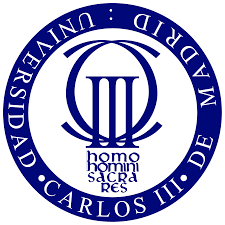


# PRÁCTICA 1: REDES DE NEURONAS
---

Autores: Pablo Hidalgo Delgado y Marcos Caballero Cortés   

NIAs: 100451225 y 100451047


# PREGUNTAS PROFE

- OHE se hace antes de la división en train y test o despues o cuando queramos

- Batch size?? 32 o 1?

- Criterio de parada --> elegir un método (early stopping) o probar con los 2?







## 1. Introducción
El propósito de esta práctica es abordar un problema real de regresión utilizando dos modelos de redes de neuronas supervisados:

*   El modelo lineal Adaline.
*   El modelo no-lineal Perceptrón Multicapa.

Para ello, se nos dispone de un conjunto de datos relacionados con medidas realizadas en una turbina de gas a lo largo de 4 años. Debemos predecir el rendimiento energético de la turbina, mostrado en el campo TEY, haciendo uso del resto de mediciones de sensores.




## 2. Leer los conjuntos de datos


En primer lugar, importamos todas las librerías que se van a utilizar a lo largo de la práctica

In [2]:
import random
import time
import pickle
import seaborn as sns
import json
from typing import Tuple


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelBinarizer

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import table

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint



Leemos los conjuntos de datos, correspondientes a las medidas de 1 solo año, y los juntamos en un mismo dataframe de pandas.

In [3]:
archivo_csv = 'dataRRNN2.csv'

datos = pd.DataFrame()

# Leemos el archivo
datos = pd.read_csv(archivo_csv)

## 3. Análisis Exploratorio de Datos (EDA)
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestro dataset. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.


### 3.1 Información básica

In [4]:
datos.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29151 entries, 0 to 29150
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    29151 non-null  float64
 1   track_id                   29151 non-null  float64
 2   mean_delta_times           29151 non-null  float64
 3   std_delta_times            29151 non-null  float64
 4   mean_hours                 29151 non-null  float64
 5   std_hours                  29151 non-null  float64
 6   mean_distances             29151 non-null  float64
 7   std_distances              29151 non-null  float64
 8   mean_velocities            29151 non-null  float64
 9   std_velocities             29151 non-null  float64
 10  mean_accelerations         29151 non-null  float64
 11  std_accelerations          29151 non-null  float64
 12  mean_headings              29151 non-null  float64
 13  std_headings               29151 non-null  flo

El conjunto de datos se compone de 29151 instancias y 22 atributos de tipo float64. La variable de salida, label, es de tipo int64.

También podemos observar que no existen columnas que contengan valores nulos.

### 3.2 Atributos irrelevantes
Hemos detectado que las columnas user_id y track_id son irrelevantes para la variable de salida ya que se tratan de identificadores.

Los identificadores no aportan información predictiva para el modelo. Además, podrían introducir un sesgo e información de la que deberíamos prescindir ya que se podría producir sobreajuste. Por estas razones, eliminamos este atributo de nuestro conjunto de datos.

### 3.2 Atributos compuestos de valores constantes

A continuación, vamos a analizar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta y no existe riesgo de information leakage.

In [5]:
# Eliminamos las columnas con solo un valor único
columnas_constantes = []
for col in datos.columns:
    if datos[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


### 3.3 Distribución de clases
Comprobamos el desbalanceo de los datos.

0    10899
1     5543
2     6558
3     4403
4     1748
Name: label, dtype: int64


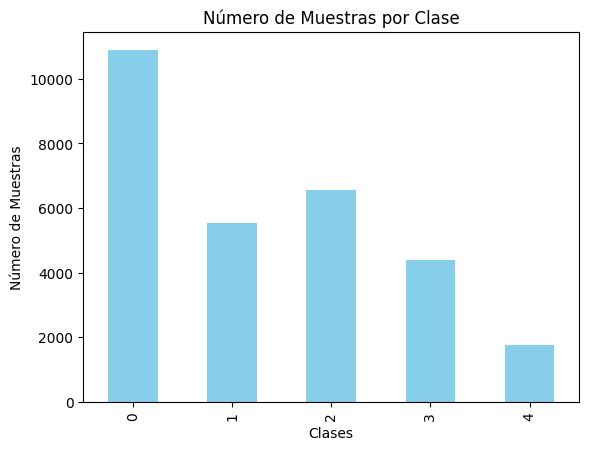

In [6]:
# Calculamos el recuento de muestras por clase y ordenamos por índice (las clases)
conteo_clases = datos['label'].value_counts().sort_index()

# Creamos la gráfica de barras
conteo_clases.plot(kind='bar', color='skyblue')
print(conteo_clases)
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Número de Muestras por Clase')
plt.show()

Vemos el claro desbalanceo de los datos siendo la clase 0 (andando) la mayoritaria y la clase 4 (en metro) la minoritaria.

## 5. Preproceso
Previamente a entrenar los modelos, debemos realizar una transformación de los datos para que puedan ser interpretados por el algoritmo de manera eficiente. Las transformaciones de datos que realizamos son las siguientes:

### 5.2 División de datos en train, validation y test.
Una vez explorado y analizado nuestro conjunto de datos, dividimos el dataset en conjuntos de entrenamiento (train), prueba (test) y validación (validation). Para ello, utilizamos la función train_test_split de la librería sklearn. Dividimos los datos en 2/3 para train y 1/3 para test. El conjunto de validación se corresponderá con un 20% del conjunto de entrenamiento tal y como se nos pide en el enunciado de la práctica.

Antes de realizar la división, debemos separar la variable de respuesta del resto del conjunto de datos.

In [7]:
X = datos.drop("label", axis = 1)
y = datos["label"]

Dividimos el conjunto de datos. Lo hacemos especificando el parámetro random_state a 40 para que se aleatorizen los datos y el resultado sea reproducible.
Además, al tratarse de un problema desbalanceado, utilizamos el parámetro stratify para realizar una partición estratificada, es decir, mantener la misma proporción de clases en ambos conjuntos.


In [8]:
# Dividimos los datos originales en conjuntos de entrenamiento (2/3) y prueba (1/3%)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=1/3, random_state=40, shuffle = True, stratify=y)

# Dividimos el conjunto de entrenamiento en conjuntos de entrenamiento (80%) y validación (20%)
X_train_raw, X_validation_raw, y_train_raw, y_validation_raw = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=40, shuffle = True, stratify=y_train_raw)

# Guardamos los conjuntos de datos en archivos CSV
X_train_raw.to_csv('X_train_raw.csv', index=False)
y_train_raw.to_csv('y_train_raw.csv', index=False)
X_validation_raw.to_csv('X_validation_raw.csv', index=False)
y_validation_raw.to_csv('y_validation_raw.csv', index=False)
X_test_raw.to_csv('X_test_raw.csv', index=False)
y_test_raw.to_csv('y_test_raw.csv', index=False)

Verificamos que existen muestras de cada clase en cada conjunto de datos. Se deberá obtener la misma proporción que se obtuvo con el conjunto de datos entero.

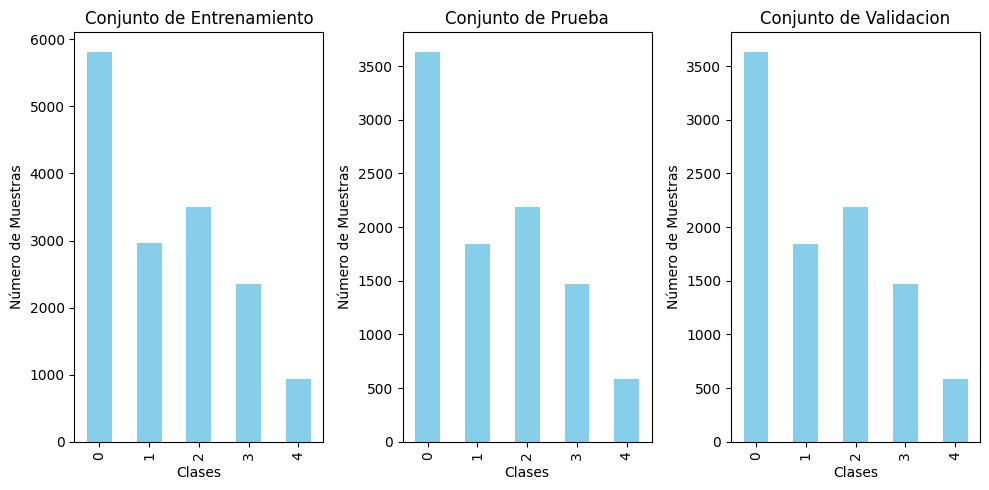

In [9]:
# Verificamos el balance de clases en los conjuntos de entrenamiento, prueba y validación
conteo_clases_train = y_train_raw.value_counts().sort_index()
conteo_clases_test = y_test_raw.value_counts().sort_index()
conteo_clases_validation = y_validation_raw.value_counts().sort_index()

# Creamos la gráfica de barras para los conjuntos de entrenamiento y prueba
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
conteo_clases_train.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Entrenamiento')

plt.subplot(1, 3, 2)
conteo_clases_test.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Prueba')


plt.subplot(1, 3, 3)
conteo_clases_test.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Validacion')

plt.tight_layout()
plt.show()

### 5.3 Codificación de la variable de salida
Al estar frente a un problema de clasificación multiclase (5 clases distintas) es importante codificar estos valores para asegurar la compatibilidad con los algoritmos de aprendizaje automático. Para ello, utilizamos la clase LabelBinarizer de scikit learn.

In [10]:
print(y_train_raw)
# Binarizamos la variable de salida usando LabelBinarizer
label_binarizer = LabelBinarizer()

# Binarizamos y_train
y_train_binarized = label_binarizer.fit_transform(y_train_raw)

# Binarizamos y_validation
y_validation_binarized = label_binarizer.transform(y_validation_raw)

print(type(y_test_raw))

# Binarizamos y_test
y_test_binarized = label_binarizer.transform(y_test_raw)

print(type(y_test_binarized))

25688    0
22960    0
12721    3
4071     1
708      2
        ..
1535     0
20962    0
10501    3
27156    2
4968     3
Name: label, Length: 15547, dtype: int64
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


### 5.1 Normalización
Para que no se produzca information leakage y no dar información al conjunto de test, normalizamos todos los datos con el mínimo y máximo obtenido del conjunto de entrenamiento.

In [11]:
X_train = X_train_raw
X_validation = X_validation_raw
X_test = X_test_raw

for columna in X_train_raw:
 # Obtenemos el minimo y el maximo de cada columna del conjunto de train
  min = X_train_raw[columna].min()
  max = X_train_raw[columna].max()
  # Conjunto de entrenamiento
  X_train[columna] = (X_train_raw[columna] - min)/(max - min)
  # Conjunto de validación
  X_validation[columna] = (X_validation_raw[columna] - min)/(max - min)
  # Conjunto de test
  X_test[columna] = (X_test_raw[columna] - min)/(max - min)

y_min = y_train_binarized.min()
y_max = y_train_binarized.max()
# Conjunto de entrenamiento
y_train = (y_train_binarized - y_min)/(y_max - y_min)
# Conjunto de validación
y_validation = (y_validation_binarized - y_min)/(y_max - y_min)
# Conjunto de test
y_test = (y_test_binarized - y_min)/(y_max - y_min)

# Guardamos los conjuntos de datos en archivos CSV
X_train.to_csv('X_train.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
X_validation.to_csv('X_validation.csv', index=False)
pd.DataFrame(y_validation).to_csv('y_validation.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

### 5.2 Aleatorización
La aleatorización de los datos la hemos realizado al dividir el conjunto de datos en train, test y validation al especificar el parametro shuffle = True.

### Balanceo

## 6. Perceptrón Multicapa

### 6.1 Implementación
Tratamos de optimizar el MSE de validación.

Criterio de parada --> Early Stopping.

In [12]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla.

def build_and_train_mlp(learning_rate, num_hidden_layers, num_neurons: Tuple[int, ...], activation_function, epochs):
    model = Sequential()

    # Capa de entrada
    model.add(Dense(num_neurons[0], activation=activation_function, input_shape=input_shape))


    # Capas ocultas
    for i in range(1, num_hidden_layers):
        model.add(Dense(num_neurons[i], activation=activation_function))

    # Capa de salida (5 clases --> 5 neuronas)
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])

    # Definimos el criterio de parada Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Especificamos una paciencia de 5 épocas y que se restauren automáticamente los pesos a la mejor época

    start_time = time.time()
    # Entrenamos el modelo
    historico = model.fit(X_train, y_train, epochs=epochs, batch_size=1, callbacks=[early_stopping], validation_data=(X_validation, y_validation))
    tiempo_total = time.time() - start_time
    print(f"Tiempo de entrenamiento para (lr = {learning_rate}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {tiempo_total}s")

    return model,historico



### 6.2 Experimentos realizados
A continuación, debemos elegir los mejores hiperparámetros para nuestro conjunto de datos. Para ello, construimos distintos modelos con diferentes hiperparámetros. Escogeremos el modelo con la combinación de hiperparámetros cuyo MSE de validación sea el menor.

Epoch 1/10
15547/15547 [==============================] - 36s 2ms/step - loss: 0.0941 - mse: 0.0941 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 2/10
15547/15547 [==============================] - 36s 2ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 3/10
15547/15547 [==============================] - 35s 2ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 0.0666 - val_mse: 0.0666
Epoch 4/10
15547/15547 [==============================] - 35s 2ms/step - loss: 0.0660 - mse: 0.0660 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 5/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0635 - mse: 0.0635 - val_loss: 0.0685 - val_mse: 0.0685
Epoch 6/10
15547/15547 [==============================] - 37s 2ms/step - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 7/10
15547/15547 [==============================] - 34s 2ms/step - loss: 0.0605 - mse: 0.0605 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


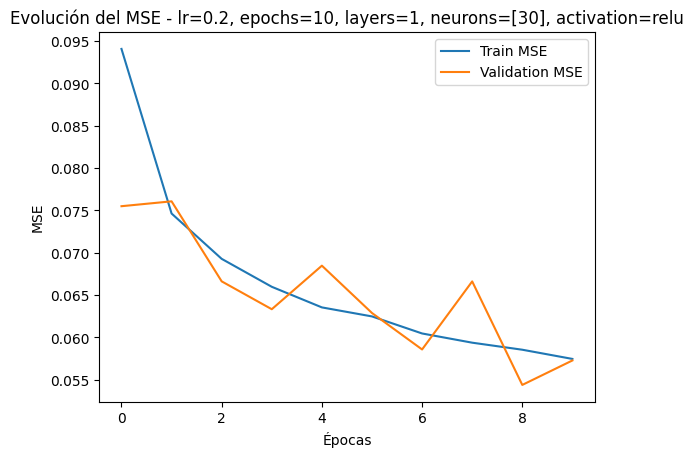

Epoch 1/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0930 - mse: 0.0930 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 2/20
15547/15547 [==============================] - 36s 2ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.0701 - val_mse: 0.0701
Epoch 3/20
15547/15547 [==============================] - 35s 2ms/step - loss: 0.0680 - mse: 0.0680 - val_loss: 0.0617 - val_mse: 0.0617
Epoch 4/20
15547/15547 [==============================] - 35s 2ms/step - loss: 0.0650 - mse: 0.0650 - val_loss: 0.0631 - val_mse: 0.0631
Epoch 5/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0633 - mse: 0.0633 - val_loss: 0.0598 - val_mse: 0.0598
Epoch 6/20
15547/15547 [==============================] - 36s 2ms/step - loss: 0.0615 - mse: 0.0615 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 7/20
15547/15547 [==============================] - 35s 2ms/step - loss: 0.0608 - mse: 0.0608 - val_loss: 0.0611 - val_mse: 0.0611
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


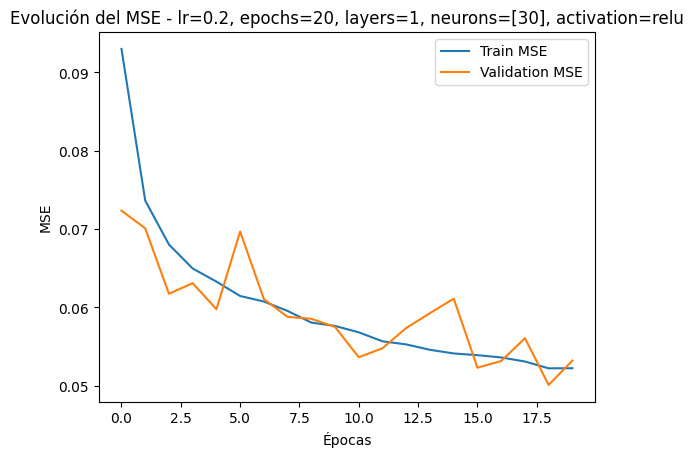

Epoch 1/10
15547/15547 [==============================] - 36s 2ms/step - loss: 0.1139 - mse: 0.1139 - val_loss: 0.0958 - val_mse: 0.0958
Epoch 2/10
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0894 - mse: 0.0894 - val_loss: 0.0866 - val_mse: 0.0866
Epoch 3/10
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0807 - mse: 0.0807 - val_loss: 0.0806 - val_mse: 0.0806
Epoch 4/10
15547/15547 [==============================] - 34s 2ms/step - loss: 0.0760 - mse: 0.0760 - val_loss: 0.0729 - val_mse: 0.0729
Epoch 5/10
15547/15547 [==============================] - 39s 3ms/step - loss: 0.0732 - mse: 0.0732 - val_loss: 0.0707 - val_mse: 0.0707
Epoch 6/10
15547/15547 [==============================] - 34s 2ms/step - loss: 0.0708 - mse: 0.0708 - val_loss: 0.0712 - val_mse: 0.0712
Epoch 7/10
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0691 - mse: 0.0691 - val_loss: 0.0677 - val_mse: 0.0677
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


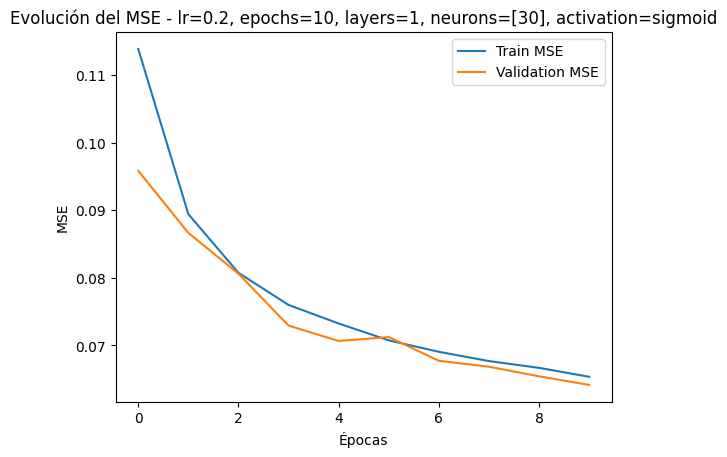

Epoch 1/20
15547/15547 [==============================] - 42s 3ms/step - loss: 0.1152 - mse: 0.1152 - val_loss: 0.0981 - val_mse: 0.0981
Epoch 2/20
15547/15547 [==============================] - 36s 2ms/step - loss: 0.0905 - mse: 0.0905 - val_loss: 0.0968 - val_mse: 0.0968
Epoch 3/20
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0814 - mse: 0.0814 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 4/20
15547/15547 [==============================] - 37s 2ms/step - loss: 0.0761 - mse: 0.0761 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 5/20
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0733 - mse: 0.0733 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 6/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0710 - mse: 0.0710 - val_loss: 0.0683 - val_mse: 0.0683
Epoch 7/20
15547/15547 [==============================] - 35s 2ms/step - loss: 0.0690 - mse: 0.0690 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


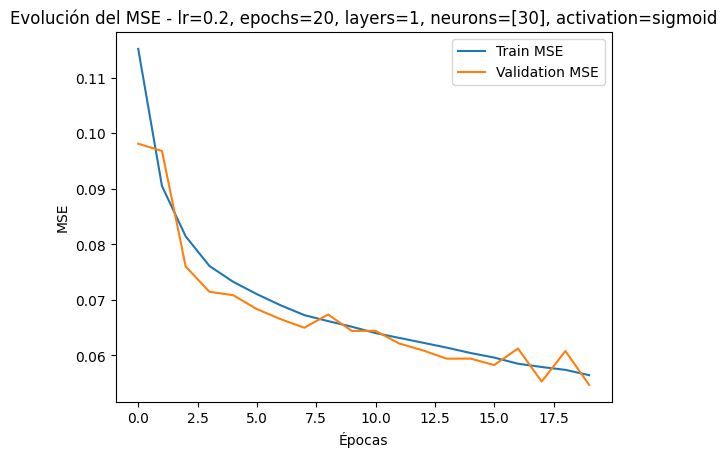

Epoch 1/10
15547/15547 [==============================] - 52s 3ms/step - loss: 0.0931 - mse: 0.0931 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 2/10
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0753 - mse: 0.0753 - val_loss: 0.0830 - val_mse: 0.0830
Epoch 3/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0698 - mse: 0.0698 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 4/10
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0663 - mse: 0.0663 - val_loss: 0.0707 - val_mse: 0.0707
Epoch 5/10
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 6/10
15547/15547 [==============================] - 38s 2ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0603 - val_mse: 0.0603
Epoch 7/10
15547/15547 [==============================] - 39s 2ms/step - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0579 - val_mse: 0.0579
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


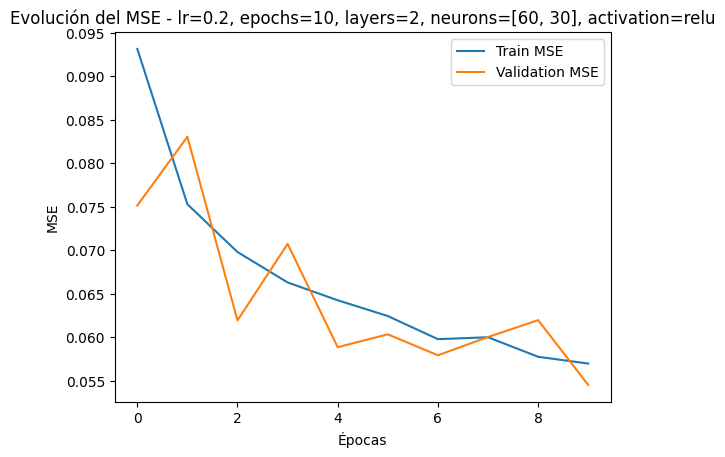

Epoch 1/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0924 - mse: 0.0924 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 2/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0751 - mse: 0.0751 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 3/20
15547/15547 [==============================] - 38s 2ms/step - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0594 - val_mse: 0.0594
Epoch 4/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0663 - mse: 0.0663 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 5/20
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0640 - mse: 0.0640 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 6/20
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0622 - mse: 0.0622 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 7/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


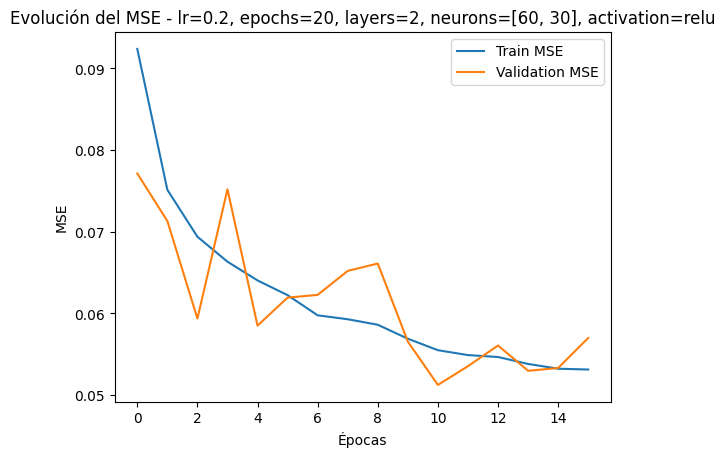

Epoch 1/10
15547/15547 [==============================] - 37s 2ms/step - loss: 0.1274 - mse: 0.1274 - val_loss: 0.1085 - val_mse: 0.1085
Epoch 2/10
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0987 - mse: 0.0987 - val_loss: 0.0910 - val_mse: 0.0910
Epoch 3/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0869 - mse: 0.0869 - val_loss: 0.0846 - val_mse: 0.0846
Epoch 4/10
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0803 - mse: 0.0803 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 5/10
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0768 - mse: 0.0768 - val_loss: 0.0739 - val_mse: 0.0739
Epoch 6/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0734 - mse: 0.0734 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 7/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0710 - mse: 0.0710 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


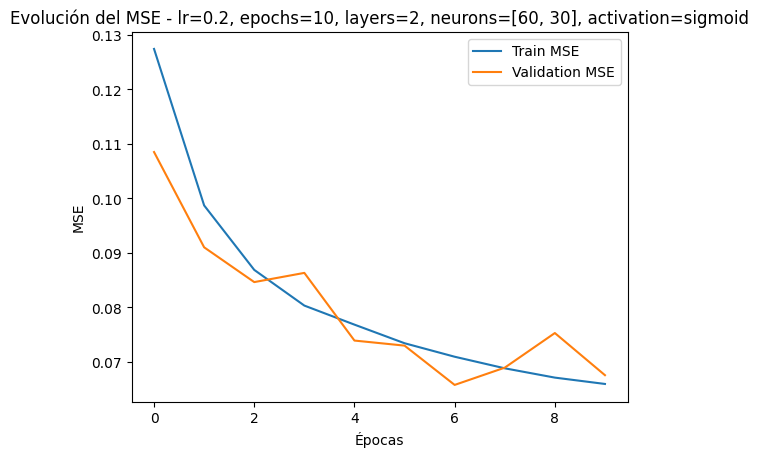

Epoch 1/20
15547/15547 [==============================] - 46s 3ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1112 - val_mse: 0.1112
Epoch 2/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0990 - mse: 0.0990 - val_loss: 0.0914 - val_mse: 0.0914
Epoch 3/20
15547/15547 [==============================] - 37s 2ms/step - loss: 0.0868 - mse: 0.0868 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 4/20
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0804 - mse: 0.0804 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 5/20
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0773 - mse: 0.0773 - val_loss: 0.0811 - val_mse: 0.0811
Epoch 6/20
15547/15547 [==============================] - 39s 3ms/step - loss: 0.0749 - mse: 0.0749 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 7/20
15547/15547 [==============================] - 37s 2ms/step - loss: 0.0719 - mse: 0.0719 - val_loss: 0.0699 - val_mse: 0.0699
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


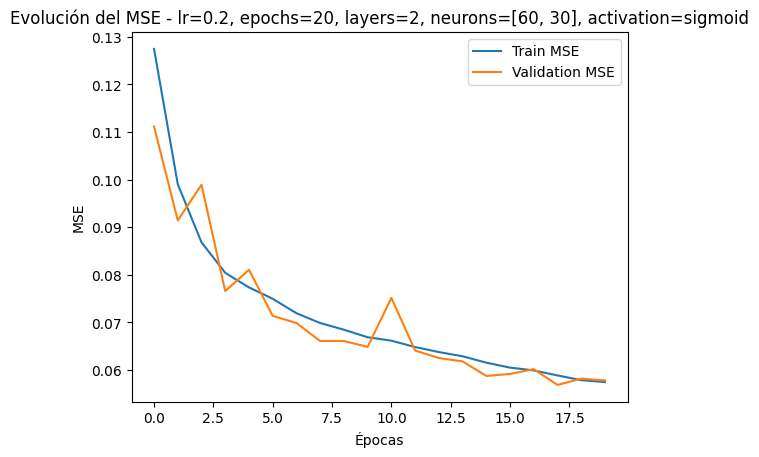

Epoch 1/10
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0875 - val_mse: 0.0875
Epoch 2/10
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0790 - mse: 0.0790 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 3/10
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0725 - mse: 0.0725 - val_loss: 0.0652 - val_mse: 0.0652
Epoch 4/10
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0691 - mse: 0.0691 - val_loss: 0.0701 - val_mse: 0.0701
Epoch 5/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0674 - mse: 0.0674 - val_loss: 0.0647 - val_mse: 0.0647
Epoch 6/10
15547/15547 [==============================] - 39s 3ms/step - loss: 0.0672 - mse: 0.0672 - val_loss: 0.0651 - val_mse: 0.0651
Epoch 7/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0646 - mse: 0.0646 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


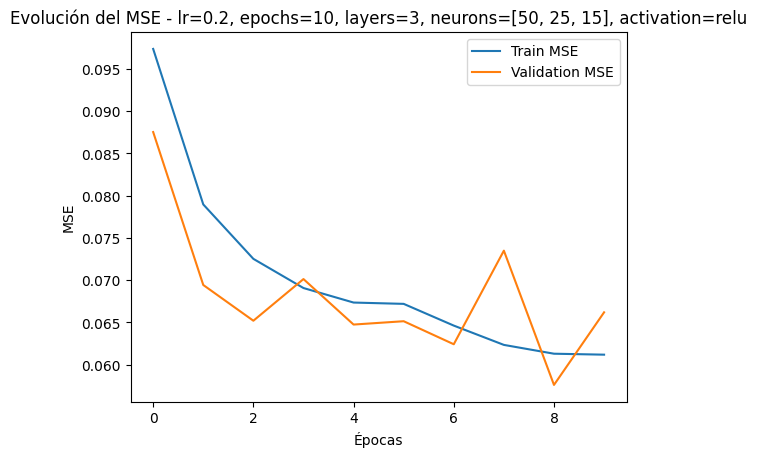

Epoch 1/20
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0968 - mse: 0.0968 - val_loss: 0.1295 - val_mse: 0.1295
Epoch 2/20
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0782 - mse: 0.0782 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 3/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 4/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0705 - mse: 0.0705 - val_loss: 0.0651 - val_mse: 0.0651
Epoch 5/20
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0677 - mse: 0.0677 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 6/20
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0661 - mse: 0.0661 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 7/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0645 - mse: 0.0645 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


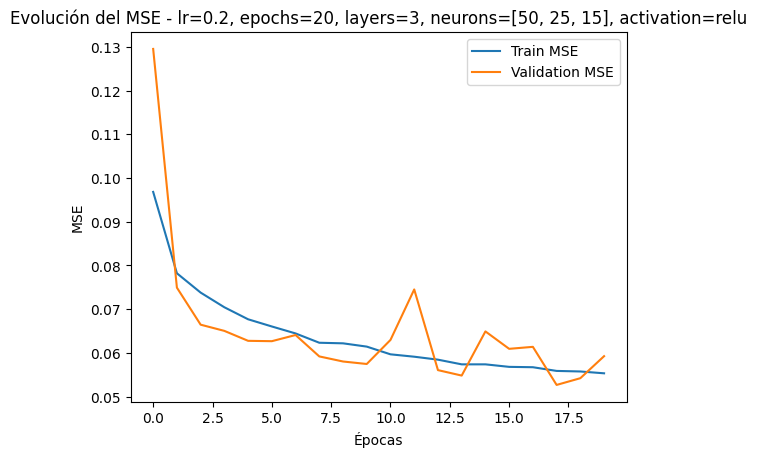

Epoch 1/10
15547/15547 [==============================] - 44s 3ms/step - loss: 0.1463 - mse: 0.1463 - val_loss: 0.1343 - val_mse: 0.1343
Epoch 2/10
15547/15547 [==============================] - 44s 3ms/step - loss: 0.1152 - mse: 0.1152 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 3/10
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1055 - mse: 0.1055 - val_loss: 0.1030 - val_mse: 0.1030
Epoch 4/10
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0970 - mse: 0.0970 - val_loss: 0.0882 - val_mse: 0.0882
Epoch 5/10
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0885 - mse: 0.0885 - val_loss: 0.0807 - val_mse: 0.0807
Epoch 6/10
15547/15547 [==============================] - 48s 3ms/step - loss: 0.0827 - mse: 0.0827 - val_loss: 0.0785 - val_mse: 0.0785
Epoch 7/10
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 0.0805 - val_mse: 0.0805
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


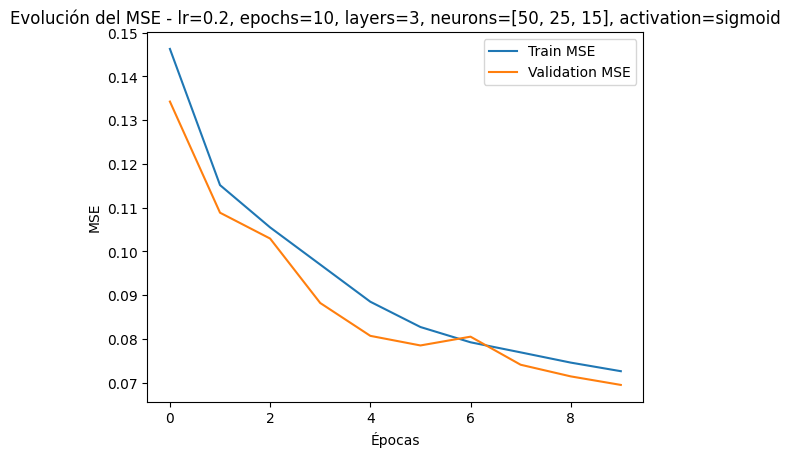

Epoch 1/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1497 - mse: 0.1497 - val_loss: 0.1471 - val_mse: 0.1471
Epoch 2/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1198 - mse: 0.1198 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 3/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1058 - mse: 0.1058 - val_loss: 0.1140 - val_mse: 0.1140
Epoch 4/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0975 - mse: 0.0975 - val_loss: 0.0963 - val_mse: 0.0963
Epoch 5/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0873 - mse: 0.0873 - val_loss: 0.0843 - val_mse: 0.0843
Epoch 6/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.0812 - mse: 0.0812 - val_loss: 0.0802 - val_mse: 0.0802
Epoch 7/20
15547/15547 [==============================] - 49s 3ms/step - loss: 0.0768 - mse: 0.0768 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


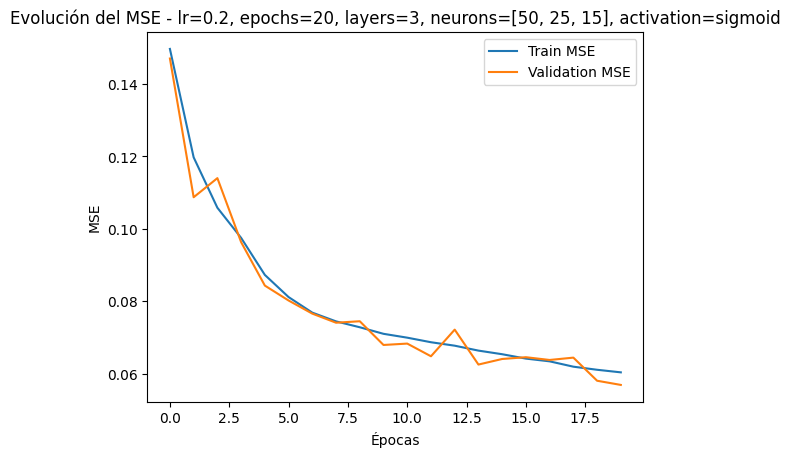

Epoch 1/10
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0984 - mse: 0.0984 - val_loss: 0.0922 - val_mse: 0.0922
Epoch 2/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0759 - mse: 0.0759 - val_loss: 0.0719 - val_mse: 0.0719
Epoch 3/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0704 - mse: 0.0704 - val_loss: 0.0657 - val_mse: 0.0657
Epoch 4/10
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0670 - mse: 0.0670 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 5/10
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0643 - mse: 0.0643 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 6/10
15547/15547 [==============================] - 39s 3ms/step - loss: 0.0619 - mse: 0.0619 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 7/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


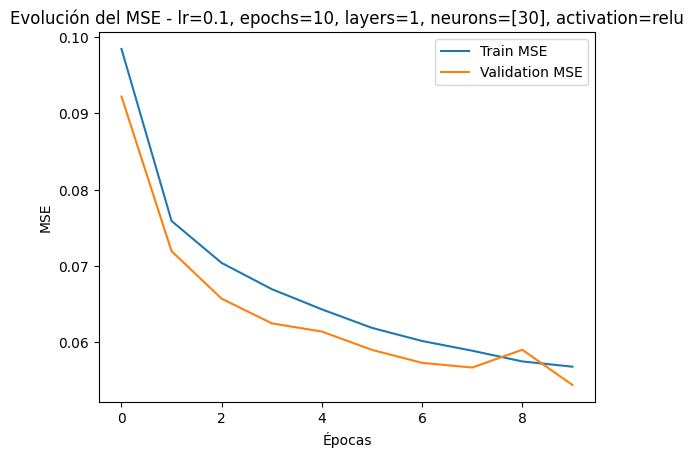

Epoch 1/20
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0996 - mse: 0.0996 - val_loss: 0.0969 - val_mse: 0.0969
Epoch 2/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0777 - mse: 0.0777 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3/20
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0711 - mse: 0.0711 - val_loss: 0.0684 - val_mse: 0.0684
Epoch 4/20
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0677 - mse: 0.0677 - val_loss: 0.0679 - val_mse: 0.0679
Epoch 5/20
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0647 - mse: 0.0647 - val_loss: 0.0673 - val_mse: 0.0673
Epoch 6/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 7/20
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0603 - mse: 0.0603 - val_loss: 0.0591 - val_mse: 0.0591
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


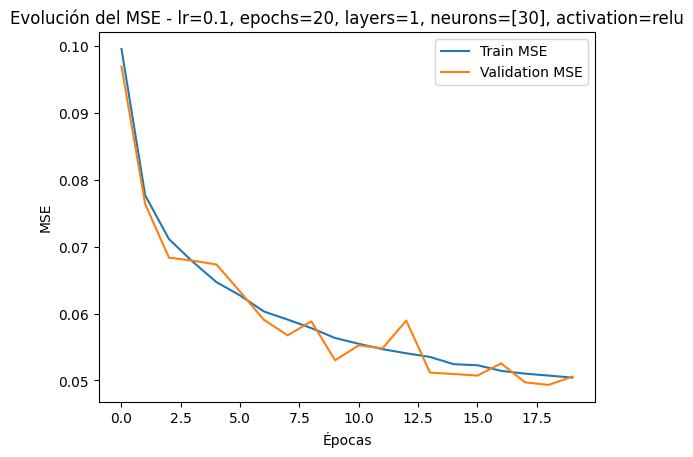

Epoch 1/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.1240 - mse: 0.1240 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 2/10
15547/15547 [==============================] - 39s 3ms/step - loss: 0.1007 - mse: 0.1007 - val_loss: 0.0942 - val_mse: 0.0942
Epoch 3/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0910 - mse: 0.0910 - val_loss: 0.0892 - val_mse: 0.0892
Epoch 4/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0849 - mse: 0.0849 - val_loss: 0.0867 - val_mse: 0.0867
Epoch 5/10
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0805 - mse: 0.0805 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 6/10
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0772 - mse: 0.0772 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 7/10
15547/15547 [==============================] - 40s 3ms/step - loss: 0.0748 - mse: 0.0748 - val_loss: 0.0739 - val_mse: 0.0739
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


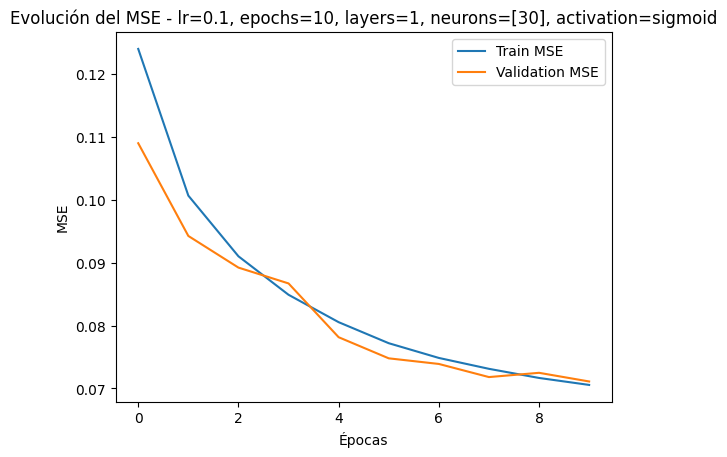

Epoch 1/20
15547/15547 [==============================] - 42s 3ms/step - loss: 0.1243 - mse: 0.1243 - val_loss: 0.1130 - val_mse: 0.1130
Epoch 2/20
15547/15547 [==============================] - 40s 3ms/step - loss: 0.1008 - mse: 0.1008 - val_loss: 0.1003 - val_mse: 0.1003
Epoch 3/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0912 - mse: 0.0912 - val_loss: 0.0874 - val_mse: 0.0874
Epoch 4/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0852 - mse: 0.0852 - val_loss: 0.0821 - val_mse: 0.0821
Epoch 5/20
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.0783 - val_mse: 0.0783
Epoch 6/20
15547/15547 [==============================] - 39s 3ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 7/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0753 - mse: 0.0753 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


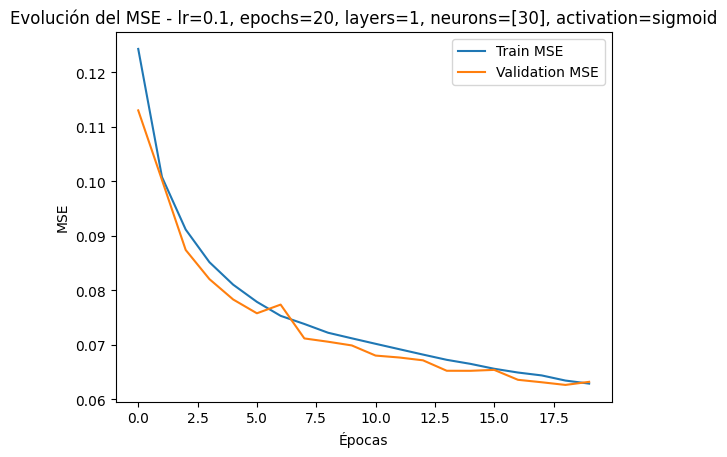

Epoch 1/10
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0942 - mse: 0.0942 - val_loss: 0.0741 - val_mse: 0.0741
Epoch 2/10
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0730 - mse: 0.0730 - val_loss: 0.0676 - val_mse: 0.0676
Epoch 3/10
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0665 - mse: 0.0665 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 4/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0554 - val_mse: 0.0554
Epoch 5/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 6/10
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 7/10
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0595 - val_mse: 0.0595
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


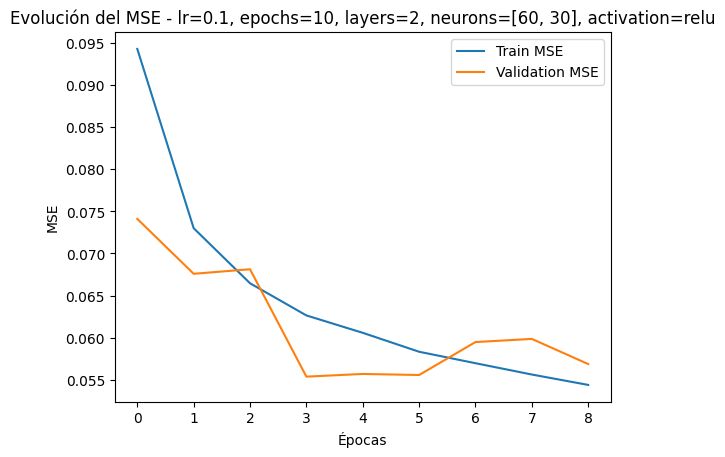

Epoch 1/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0950 - mse: 0.0950 - val_loss: 0.0825 - val_mse: 0.0825
Epoch 2/20
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0741 - mse: 0.0741 - val_loss: 0.0727 - val_mse: 0.0727
Epoch 3/20
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0671 - mse: 0.0671 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 4/20
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 5/20
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0608 - mse: 0.0608 - val_loss: 0.0597 - val_mse: 0.0597
Epoch 6/20
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0586 - mse: 0.0586 - val_loss: 0.0595 - val_mse: 0.0595
Epoch 7/20
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


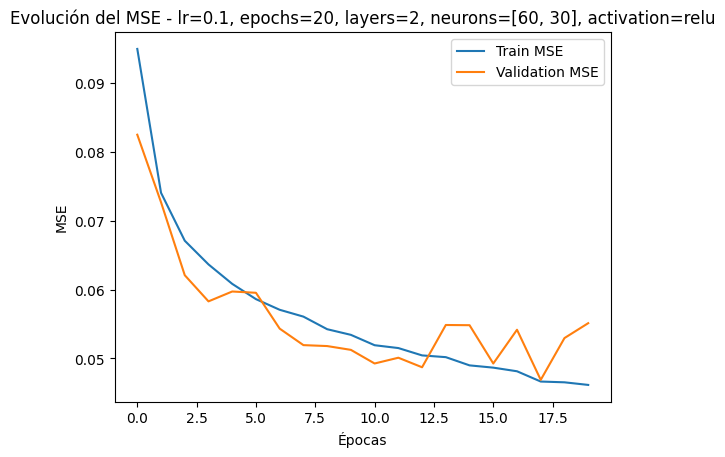

Epoch 1/10
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1366 - mse: 0.1366 - val_loss: 0.1253 - val_mse: 0.1253
Epoch 2/10
15547/15547 [==============================] - 43s 3ms/step - loss: 0.1118 - mse: 0.1118 - val_loss: 0.1034 - val_mse: 0.1034
Epoch 3/10
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0967 - mse: 0.0967 - val_loss: 0.0950 - val_mse: 0.0950
Epoch 4/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0883 - mse: 0.0883 - val_loss: 0.0846 - val_mse: 0.0846
Epoch 5/10
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0829 - mse: 0.0829 - val_loss: 0.0891 - val_mse: 0.0891
Epoch 6/10
15547/15547 [==============================] - 48s 3ms/step - loss: 0.0797 - mse: 0.0797 - val_loss: 0.0936 - val_mse: 0.0936
Epoch 7/10
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.0740 - val_mse: 0.0740
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


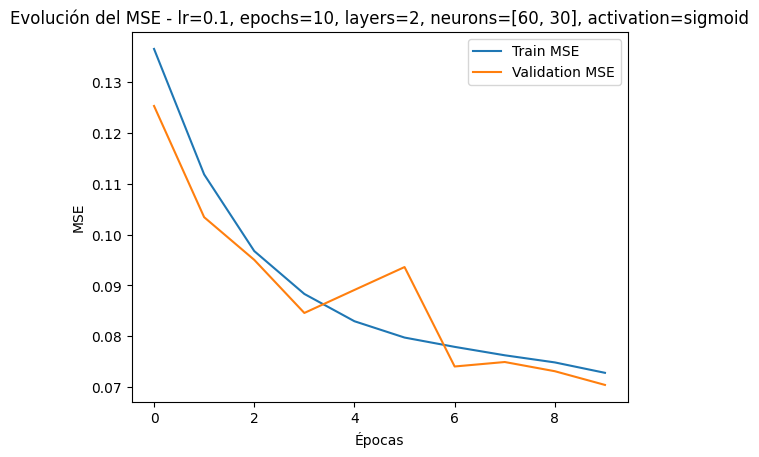

Epoch 1/20
15547/15547 [==============================] - 44s 3ms/step - loss: 0.1390 - mse: 0.1390 - val_loss: 0.1235 - val_mse: 0.1235
Epoch 2/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1128 - mse: 0.1128 - val_loss: 0.1031 - val_mse: 0.1031
Epoch 3/20
15547/15547 [==============================] - 42s 3ms/step - loss: 0.0977 - mse: 0.0977 - val_loss: 0.0945 - val_mse: 0.0945
Epoch 4/20
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0891 - mse: 0.0891 - val_loss: 0.0857 - val_mse: 0.0857
Epoch 5/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0837 - mse: 0.0837 - val_loss: 0.0796 - val_mse: 0.0796
Epoch 6/20
15547/15547 [==============================] - 41s 3ms/step - loss: 0.0804 - mse: 0.0804 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 7/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0781 - mse: 0.0781 - val_loss: 0.0815 - val_mse: 0.0815
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


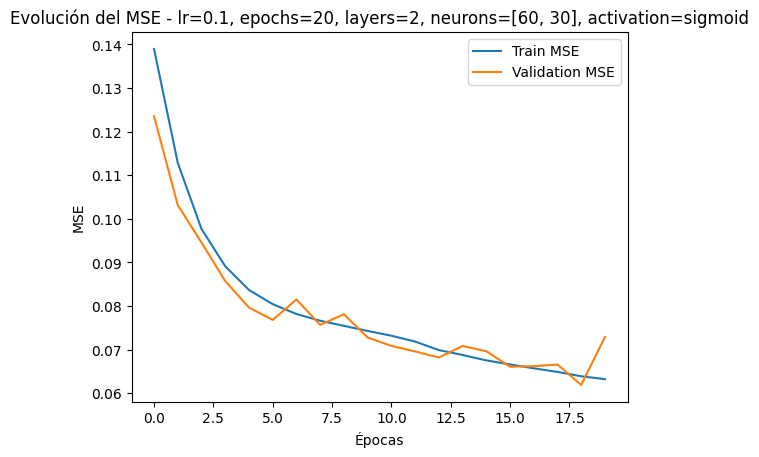

Epoch 1/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0980 - mse: 0.0980 - val_loss: 0.0846 - val_mse: 0.0846
Epoch 2/10
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0782 - mse: 0.0782 - val_loss: 0.0719 - val_mse: 0.0719
Epoch 3/10
15547/15547 [==============================] - 43s 3ms/step - loss: 0.0714 - mse: 0.0714 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 4/10
15547/15547 [==============================] - 51s 3ms/step - loss: 0.0674 - mse: 0.0674 - val_loss: 0.0605 - val_mse: 0.0605
Epoch 5/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0650 - mse: 0.0650 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 6/10
15547/15547 [==============================] - 48s 3ms/step - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0672 - val_mse: 0.0672
Epoch 7/10
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0610 - mse: 0.0610 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


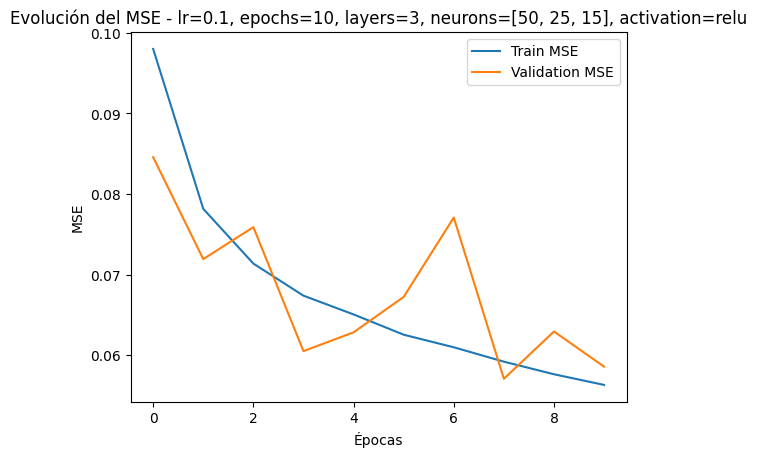

Epoch 1/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0972 - mse: 0.0972 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 2/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 3/20
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0705 - mse: 0.0705 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 4/20
15547/15547 [==============================] - 46s 3ms/step - loss: 0.0660 - mse: 0.0660 - val_loss: 0.0638 - val_mse: 0.0638
Epoch 5/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.0638 - mse: 0.0638 - val_loss: 0.0594 - val_mse: 0.0594
Epoch 6/20
15547/15547 [==============================] - 52s 3ms/step - loss: 0.0612 - mse: 0.0612 - val_loss: 0.0592 - val_mse: 0.0592
Epoch 7/20
15547/15547 [==============================] - 51s 3ms/step - loss: 0.0599 - mse: 0.0599 - val_loss: 0.0562 - val_mse: 0.0562
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


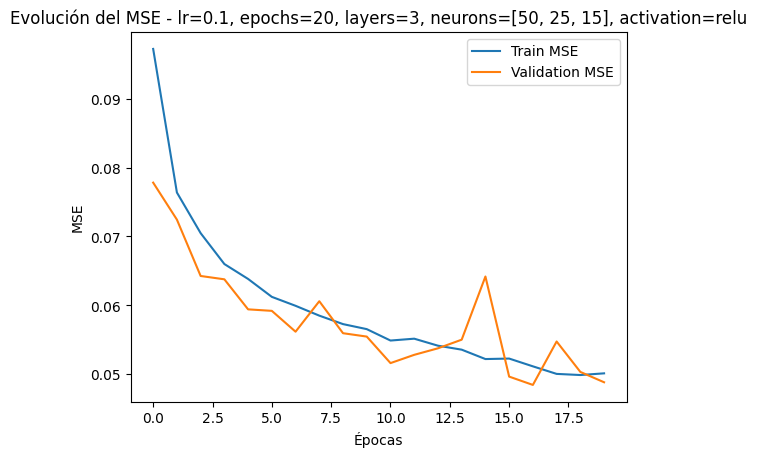

Epoch 1/10
15547/15547 [==============================] - 55s 3ms/step - loss: 0.1499 - mse: 0.1499 - val_loss: 0.1484 - val_mse: 0.1484
Epoch 2/10
15547/15547 [==============================] - 53s 3ms/step - loss: 0.1309 - mse: 0.1309 - val_loss: 0.1172 - val_mse: 0.1172
Epoch 3/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1126 - mse: 0.1126 - val_loss: 0.1063 - val_mse: 0.1063
Epoch 4/10
15547/15547 [==============================] - 52s 3ms/step - loss: 0.1061 - mse: 0.1061 - val_loss: 0.1133 - val_mse: 0.1133
Epoch 5/10
15547/15547 [==============================] - 55s 4ms/step - loss: 0.1029 - mse: 0.1029 - val_loss: 0.0996 - val_mse: 0.0996
Epoch 6/10
15547/15547 [==============================] - 53s 3ms/step - loss: 0.1005 - mse: 0.1005 - val_loss: 0.0981 - val_mse: 0.0981
Epoch 7/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.0956 - mse: 0.0956 - val_loss: 0.0897 - val_mse: 0.0897
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


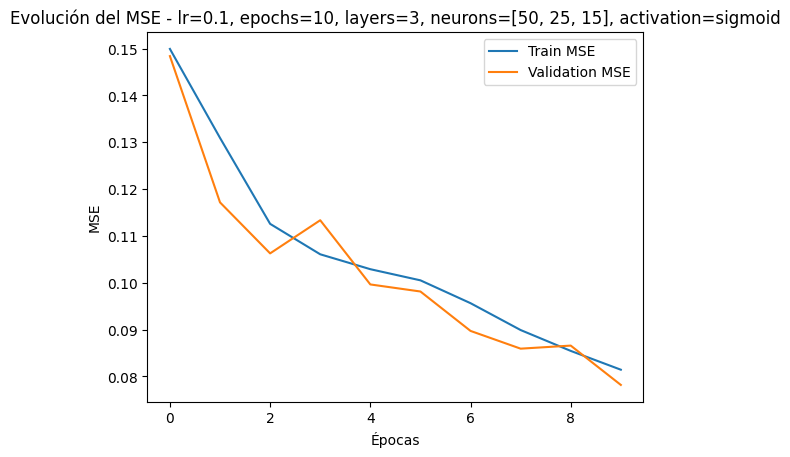

Epoch 1/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1502 - mse: 0.1502 - val_loss: 0.1494 - val_mse: 0.1494
Epoch 2/20
15547/15547 [==============================] - 52s 3ms/step - loss: 0.1466 - mse: 0.1466 - val_loss: 0.1341 - val_mse: 0.1341
Epoch 3/20
15547/15547 [==============================] - 52s 3ms/step - loss: 0.1202 - mse: 0.1202 - val_loss: 0.1138 - val_mse: 0.1138
Epoch 4/20
15547/15547 [==============================] - 54s 3ms/step - loss: 0.1092 - mse: 0.1092 - val_loss: 0.1058 - val_mse: 0.1058
Epoch 5/20
15547/15547 [==============================] - 55s 4ms/step - loss: 0.1039 - mse: 0.1039 - val_loss: 0.1001 - val_mse: 0.1001
Epoch 6/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0991 - mse: 0.0991 - val_loss: 0.0920 - val_mse: 0.0920
Epoch 7/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.0915 - mse: 0.0915 - val_loss: 0.0854 - val_mse: 0.0854
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


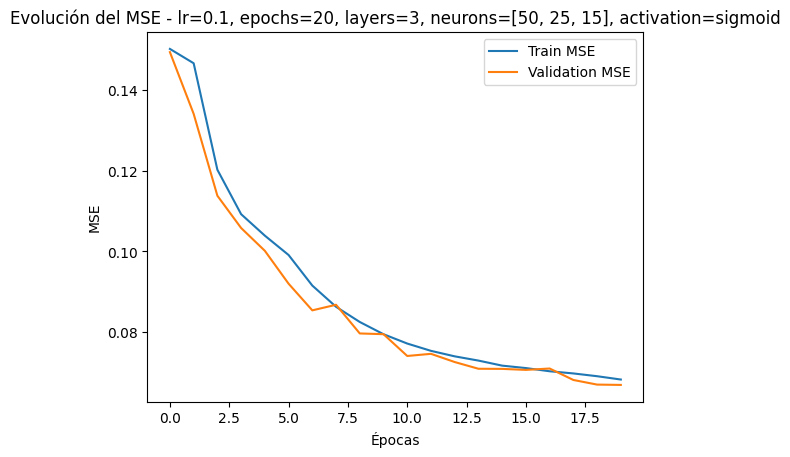

Epoch 1/10
15547/15547 [==============================] - 51s 3ms/step - loss: 0.1305 - mse: 0.1305 - val_loss: 0.1181 - val_mse: 0.1181
Epoch 2/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.1117 - mse: 0.1117 - val_loss: 0.1067 - val_mse: 0.1067
Epoch 3/10
15547/15547 [==============================] - 49s 3ms/step - loss: 0.1028 - mse: 0.1028 - val_loss: 0.0994 - val_mse: 0.0994
Epoch 4/10
15547/15547 [==============================] - 49s 3ms/step - loss: 0.0966 - mse: 0.0966 - val_loss: 0.0942 - val_mse: 0.0942
Epoch 5/10
15547/15547 [==============================] - 44s 3ms/step - loss: 0.0917 - mse: 0.0917 - val_loss: 0.0901 - val_mse: 0.0901
Epoch 6/10
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0876 - mse: 0.0876 - val_loss: 0.0857 - val_mse: 0.0857
Epoch 7/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.0840 - mse: 0.0840 - val_loss: 0.0825 - val_mse: 0.0825
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


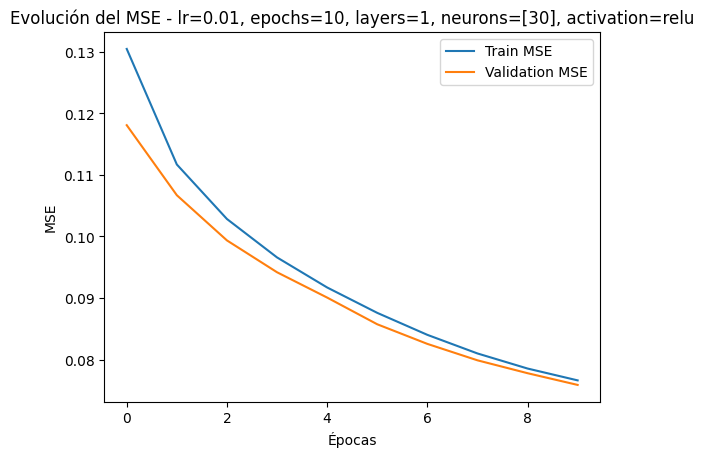

Epoch 1/20
15547/15547 [==============================] - 46s 3ms/step - loss: 0.1339 - mse: 0.1339 - val_loss: 0.1225 - val_mse: 0.1225
Epoch 2/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1152 - mse: 0.1152 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 3/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1041 - mse: 0.1041 - val_loss: 0.1005 - val_mse: 0.1005
Epoch 4/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.0969 - mse: 0.0969 - val_loss: 0.0942 - val_mse: 0.0942
Epoch 5/20
15547/15547 [==============================] - 54s 3ms/step - loss: 0.0917 - mse: 0.0917 - val_loss: 0.0893 - val_mse: 0.0893
Epoch 6/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0873 - mse: 0.0873 - val_loss: 0.0870 - val_mse: 0.0870
Epoch 7/20
15547/15547 [==============================] - 49s 3ms/step - loss: 0.0836 - mse: 0.0836 - val_loss: 0.0823 - val_mse: 0.0823
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


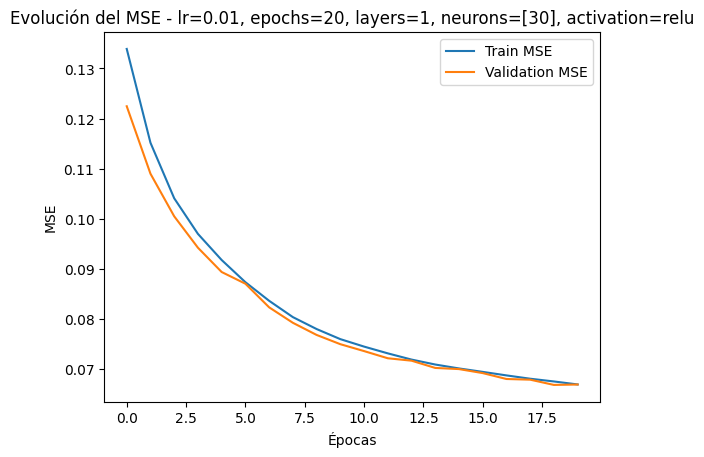

Epoch 1/10
15547/15547 [==============================] - 46s 3ms/step - loss: 0.1456 - mse: 0.1456 - val_loss: 0.1413 - val_mse: 0.1413
Epoch 2/10
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1372 - mse: 0.1372 - val_loss: 0.1334 - val_mse: 0.1334
Epoch 3/10
15547/15547 [==============================] - 49s 3ms/step - loss: 0.1299 - mse: 0.1299 - val_loss: 0.1272 - val_mse: 0.1272
Epoch 4/10
15547/15547 [==============================] - 51s 3ms/step - loss: 0.1246 - mse: 0.1246 - val_loss: 0.1232 - val_mse: 0.1232
Epoch 5/10
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1208 - mse: 0.1208 - val_loss: 0.1195 - val_mse: 0.1195
Epoch 6/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1176 - mse: 0.1176 - val_loss: 0.1166 - val_mse: 0.1166
Epoch 7/10
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1146 - mse: 0.1146 - val_loss: 0.1137 - val_mse: 0.1137
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


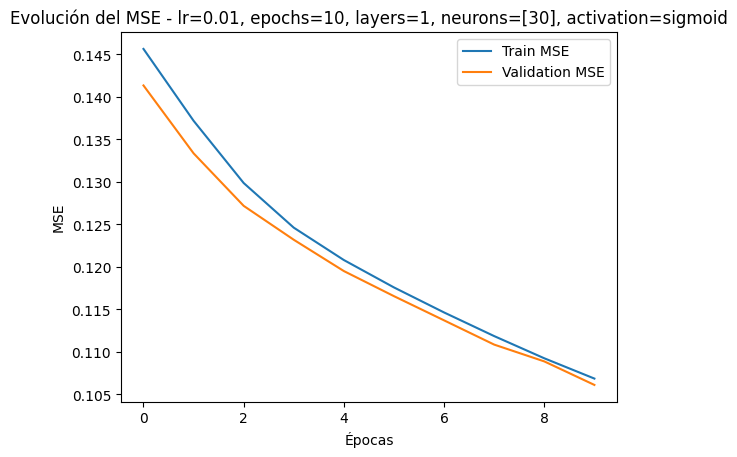

Epoch 1/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.1464 - mse: 0.1464 - val_loss: 0.1433 - val_mse: 0.1433
Epoch 2/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1395 - mse: 0.1395 - val_loss: 0.1358 - val_mse: 0.1358
Epoch 3/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1321 - mse: 0.1321 - val_loss: 0.1291 - val_mse: 0.1291
Epoch 4/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.1263 - mse: 0.1263 - val_loss: 0.1246 - val_mse: 0.1246
Epoch 5/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1223 - mse: 0.1223 - val_loss: 0.1211 - val_mse: 0.1211
Epoch 6/20
15547/15547 [==============================] - 43s 3ms/step - loss: 0.1192 - mse: 0.1192 - val_loss: 0.1182 - val_mse: 0.1182
Epoch 7/20
15547/15547 [==============================] - 45s 3ms/step - loss: 0.1164 - mse: 0.1164 - val_loss: 0.1156 - val_mse: 0.1156
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


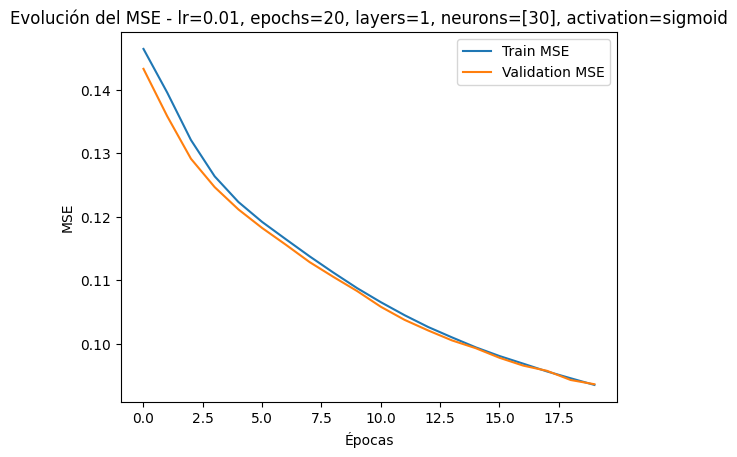

Epoch 1/10
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1277 - mse: 0.1277 - val_loss: 0.1156 - val_mse: 0.1156
Epoch 2/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1057 - mse: 0.1057 - val_loss: 0.0991 - val_mse: 0.0991
Epoch 3/10
15547/15547 [==============================] - 45s 3ms/step - loss: 0.0914 - mse: 0.0914 - val_loss: 0.0860 - val_mse: 0.0860
Epoch 4/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.0825 - mse: 0.0825 - val_loss: 0.0784 - val_mse: 0.0784
Epoch 5/10
15547/15547 [==============================] - 49s 3ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 6/10
15547/15547 [==============================] - 47s 3ms/step - loss: 0.0725 - mse: 0.0725 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 7/10
15547/15547 [==============================] - 51s 3ms/step - loss: 0.0695 - mse: 0.0695 - val_loss: 0.0682 - val_mse: 0.0682
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


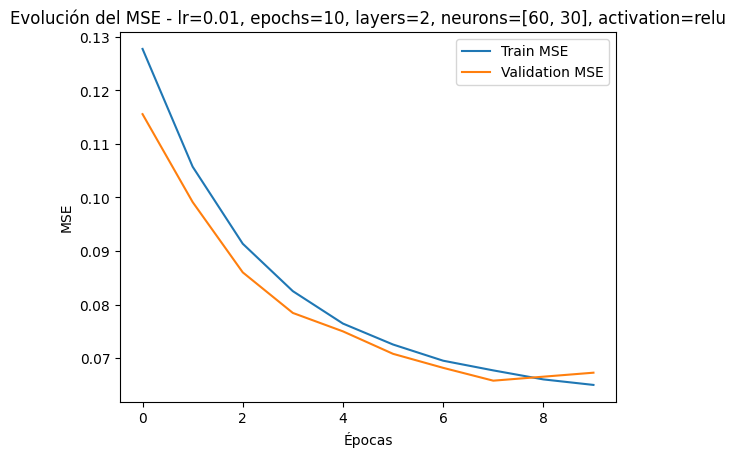

Epoch 1/20
15547/15547 [==============================] - 51s 3ms/step - loss: 0.1244 - mse: 0.1244 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 2/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1001 - mse: 0.1001 - val_loss: 0.0946 - val_mse: 0.0946
Epoch 3/20
15547/15547 [==============================] - 51s 3ms/step - loss: 0.0884 - mse: 0.0884 - val_loss: 0.0833 - val_mse: 0.0833
Epoch 4/20
15547/15547 [==============================] - 53s 3ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 5/20
15547/15547 [==============================] - 49s 3ms/step - loss: 0.0757 - mse: 0.0757 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 6/20
15547/15547 [==============================] - 49s 3ms/step - loss: 0.0723 - mse: 0.0723 - val_loss: 0.0716 - val_mse: 0.0716
Epoch 7/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


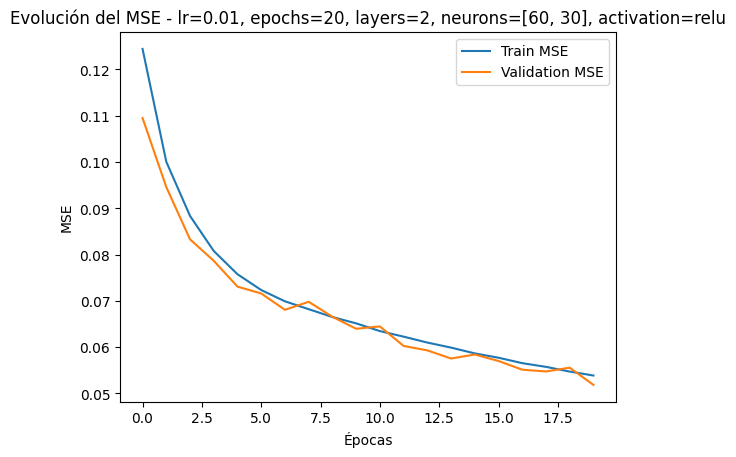

Epoch 1/10
15547/15547 [==============================] - 52s 3ms/step - loss: 0.1497 - mse: 0.1497 - val_loss: 0.1486 - val_mse: 0.1486
Epoch 2/10
15547/15547 [==============================] - 53s 3ms/step - loss: 0.1481 - mse: 0.1481 - val_loss: 0.1475 - val_mse: 0.1475
Epoch 3/10
15547/15547 [==============================] - 51s 3ms/step - loss: 0.1465 - mse: 0.1465 - val_loss: 0.1454 - val_mse: 0.1454
Epoch 4/10
15547/15547 [==============================] - 51s 3ms/step - loss: 0.1436 - mse: 0.1436 - val_loss: 0.1414 - val_mse: 0.1414
Epoch 5/10
15547/15547 [==============================] - 52s 3ms/step - loss: 0.1383 - mse: 0.1383 - val_loss: 0.1350 - val_mse: 0.1350
Epoch 6/10
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1313 - mse: 0.1313 - val_loss: 0.1288 - val_mse: 0.1288
Epoch 7/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1260 - mse: 0.1260 - val_loss: 0.1245 - val_mse: 0.1245
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


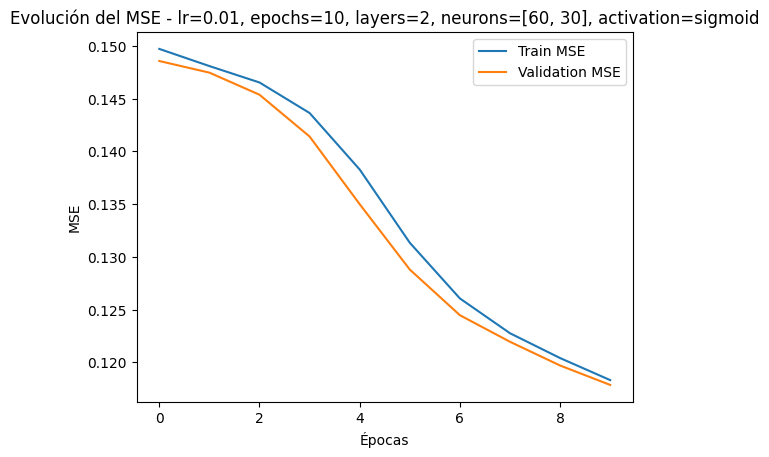

Epoch 1/20
15547/15547 [==============================] - 53s 3ms/step - loss: 0.1503 - mse: 0.1503 - val_loss: 0.1485 - val_mse: 0.1485
Epoch 2/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1480 - mse: 0.1480 - val_loss: 0.1474 - val_mse: 0.1474
Epoch 3/20
15547/15547 [==============================] - 54s 3ms/step - loss: 0.1465 - mse: 0.1465 - val_loss: 0.1452 - val_mse: 0.1452
Epoch 4/20
15547/15547 [==============================] - 51s 3ms/step - loss: 0.1436 - mse: 0.1436 - val_loss: 0.1415 - val_mse: 0.1415
Epoch 5/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1385 - mse: 0.1385 - val_loss: 0.1351 - val_mse: 0.1351
Epoch 6/20
15547/15547 [==============================] - 44s 3ms/step - loss: 0.1320 - mse: 0.1320 - val_loss: 0.1291 - val_mse: 0.1291
Epoch 7/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1268 - mse: 0.1268 - val_loss: 0.1252 - val_mse: 0.1252
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


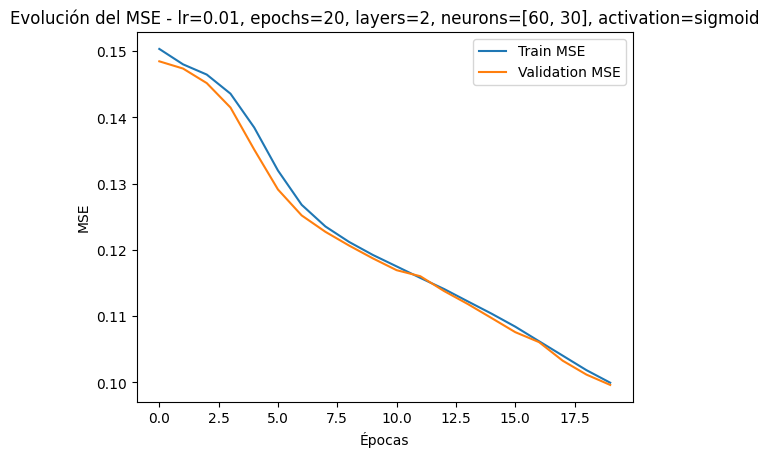

Epoch 1/10
15547/15547 [==============================] - 57s 4ms/step - loss: 0.1326 - mse: 0.1326 - val_loss: 0.1179 - val_mse: 0.1179
Epoch 2/10
15547/15547 [==============================] - 56s 4ms/step - loss: 0.1056 - mse: 0.1056 - val_loss: 0.0949 - val_mse: 0.0949
Epoch 3/10
15547/15547 [==============================] - 48s 3ms/step - loss: 0.0892 - mse: 0.0892 - val_loss: 0.0852 - val_mse: 0.0852
Epoch 4/10
15547/15547 [==============================] - 60s 4ms/step - loss: 0.0815 - mse: 0.0815 - val_loss: 0.0797 - val_mse: 0.0797
Epoch 5/10
15547/15547 [==============================] - 57s 4ms/step - loss: 0.0771 - mse: 0.0771 - val_loss: 0.0734 - val_mse: 0.0734
Epoch 6/10
15547/15547 [==============================] - 51s 3ms/step - loss: 0.0742 - mse: 0.0742 - val_loss: 0.0814 - val_mse: 0.0814
Epoch 7/10
15547/15547 [==============================] - 52s 3ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


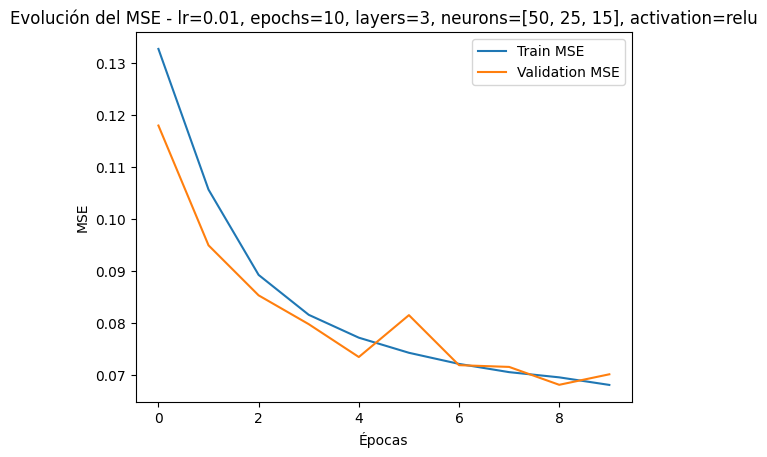

Epoch 1/20
15547/15547 [==============================] - 53s 3ms/step - loss: 0.1352 - mse: 0.1352 - val_loss: 0.1215 - val_mse: 0.1215
Epoch 2/20
15547/15547 [==============================] - 52s 3ms/step - loss: 0.1142 - mse: 0.1142 - val_loss: 0.1060 - val_mse: 0.1060
Epoch 3/20
15547/15547 [==============================] - 53s 3ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0886 - val_mse: 0.0886
Epoch 4/20
15547/15547 [==============================] - 53s 3ms/step - loss: 0.0838 - mse: 0.0838 - val_loss: 0.0794 - val_mse: 0.0794
Epoch 5/20
15547/15547 [==============================] - 54s 3ms/step - loss: 0.0756 - mse: 0.0756 - val_loss: 0.0815 - val_mse: 0.0815
Epoch 6/20
15547/15547 [==============================] - 49s 3ms/step - loss: 0.0717 - mse: 0.0717 - val_loss: 0.0693 - val_mse: 0.0693
Epoch 7/20
15547/15547 [==============================] - 52s 3ms/step - loss: 0.0689 - mse: 0.0689 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


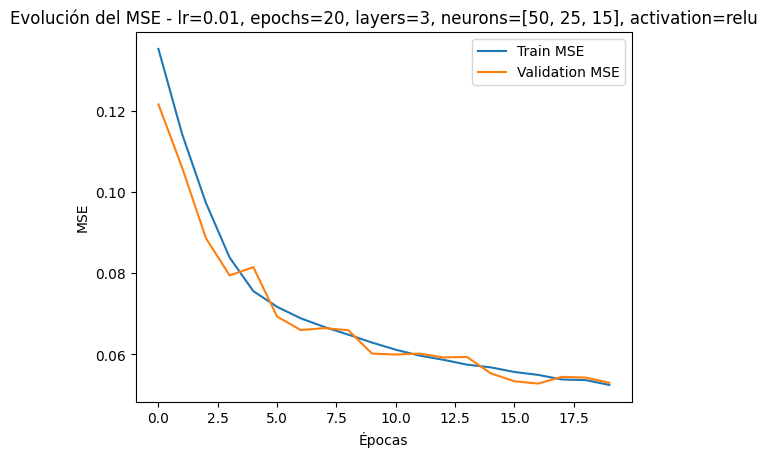

Epoch 1/10
15547/15547 [==============================] - 49s 3ms/step - loss: 0.1506 - mse: 0.1506 - val_loss: 0.1495 - val_mse: 0.1495
Epoch 2/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1495 - mse: 0.1495 - val_loss: 0.1494 - val_mse: 0.1494
Epoch 3/10
15547/15547 [==============================] - 53s 3ms/step - loss: 0.1495 - mse: 0.1495 - val_loss: 0.1494 - val_mse: 0.1494
Epoch 4/10
15547/15547 [==============================] - 49s 3ms/step - loss: 0.1494 - mse: 0.1494 - val_loss: 0.1494 - val_mse: 0.1494
Epoch 5/10
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1494 - mse: 0.1494 - val_loss: 0.1496 - val_mse: 0.1496
Epoch 6/10
15547/15547 [==============================] - 54s 3ms/step - loss: 0.1493 - mse: 0.1493 - val_loss: 0.1492 - val_mse: 0.1492
Epoch 7/10
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1493 - mse: 0.1493 - val_loss: 0.1492 - val_mse: 0.1492
Epoch 8/10
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


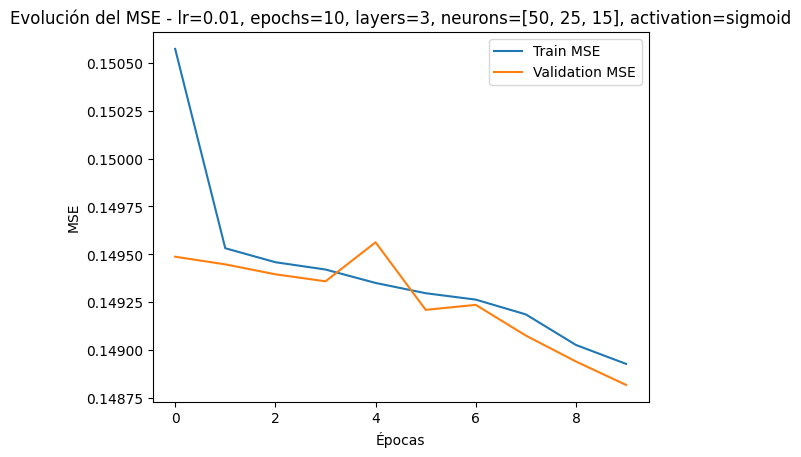

Epoch 1/20
15547/15547 [==============================] - 50s 3ms/step - loss: 0.1511 - mse: 0.1511 - val_loss: 0.1495 - val_mse: 0.1495
Epoch 2/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1494 - mse: 0.1494 - val_loss: 0.1493 - val_mse: 0.1493
Epoch 3/20
15547/15547 [==============================] - 48s 3ms/step - loss: 0.1494 - mse: 0.1494 - val_loss: 0.1493 - val_mse: 0.1493
Epoch 4/20
15547/15547 [==============================] - 49s 3ms/step - loss: 0.1492 - mse: 0.1492 - val_loss: 0.1492 - val_mse: 0.1492
Epoch 5/20
15547/15547 [==============================] - 49s 3ms/step - loss: 0.1492 - mse: 0.1492 - val_loss: 0.1491 - val_mse: 0.1491
Epoch 6/20
15547/15547 [==============================] - 47s 3ms/step - loss: 0.1491 - mse: 0.1491 - val_loss: 0.1490 - val_mse: 0.1490
Epoch 7/20
15547/15547 [==============================] - 56s 4ms/step - loss: 0.1490 - mse: 0.1490 - val_loss: 0.1488 - val_mse: 0.1488
Epoch 8/20
15547/15547 [=================

<ipython-input-13-96046bd2143d>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


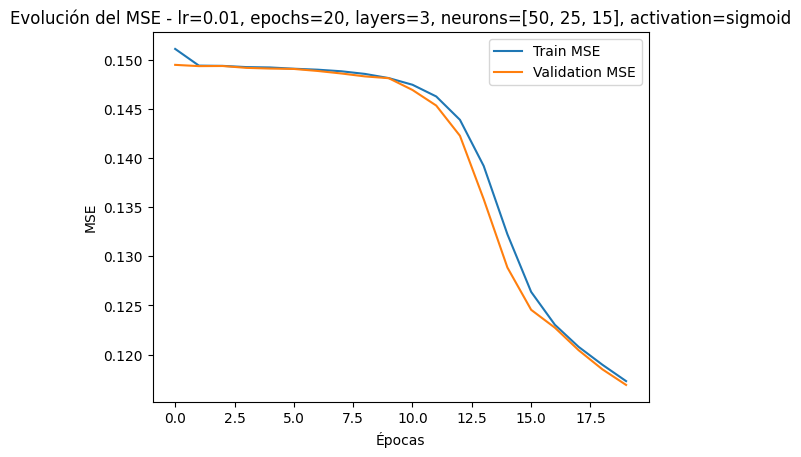

    Learning Rate Hidden Layers       Neurons Activation Function Epochs  \
0            0.20             1          [30]                relu     10   
1            0.20             1          [30]                relu     20   
2            0.20             1          [30]             sigmoid     10   
3            0.20             1          [30]             sigmoid     20   
4            0.20             2      [60, 30]                relu     10   
5            0.20             2      [60, 30]                relu     20   
6            0.20             2      [60, 30]             sigmoid     10   
7            0.20             2      [60, 30]             sigmoid     20   
8            0.20             3  [50, 25, 15]                relu     10   
9            0.20             3  [50, 25, 15]                relu     20   
10           0.20             3  [50, 25, 15]             sigmoid     10   
11           0.20             3  [50, 25, 15]             sigmoid     20   
12          

'\n# Definimos una lista de valores para learning rates, número de neuronas ocultas y épocas\nlearning_rates = [0.5, 0.4, 0.2, 0.1, 0.01]\nhidden_layers = [1,2,3]\nnum_hidden_neurons = [[50], 20, 30]\nepochs_list = [30, 50, 100]\nfuncion_activacion = [\'relu\', \'sigmoid\']\nbatch_size = 32\n\n# Creamos un diccionario para almacenar los resultados y poder mostrarlos en una tabla\nresults = {\n    \'Learning Rate\': [],\n    \'Epochs\': [],\n    \'Best Epoch\': [],\n    \'Neuronas\': [],\n    \'MSE Train\': [],\n    \'MSE Validation\': [],\n    \'MSE Test\' : []\n}\n\n# Configuramos el diseño de las gráficas\nfig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(18, 18))\nfig.subplots_adjust(hspace=0.5, wspace=0.5)  # Ajustamos el espacio vertical y horizontal\n\n# Iteramos sobre las tasas de aprendizaje\nfor i, lr in enumerate(learning_rates):\n    # Para cada época\n    for k, epochs in enumerate(epochs_list):\n        # Creamos una paleta de colores\n        palett

In [13]:
# Definimos las listas de valores para los hiperparámetros
learning_rates = [0.2, 0.1, 0.05]
hidden_layers_list = {1: [30],
                      2: [60,30],
                      3: [50,25,15]}
activation_functions = ['relu', 'sigmoid']
epochs_list = [20, 30]

# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['Learning Rate', 'Hidden Layers', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo de Entrenamiento' 'Train MSE', 'Validation MSE', 'Test MSE'])

# Iteramos sobre todas las combinaciones de hiperparámetros
for lr in learning_rates:
    for num_hidden_layers, num_neurons in hidden_layers_list.items():  # Utilizamos items() para obtener tanto la clave como el valor del diccionario
        for activation_function in activation_functions:
            for epochs in epochs_list:

                start_time = time.time()
                # Construimos y entrenamos un modelo con los hiperparámetros actuales
                modelo, historico = build_and_train_mlp(lr, num_hidden_layers, num_neurons, activation_function, epochs)
                tiempo_total = time.time() - start_time

                # Obtenemos las predicciones
                prediccion = modelo.predict(X_test)
                # Obtenemos el MSE de test
                mse_test = mean_squared_error(y_test, prediccion)
                print(f"MSE de test ((lr = {lr}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {mse_test:.2e}")

                # Obtenemos los errores de entrenamiento y validación
                mse_train = historico.history['loss']
                mse_val = historico.history['val_loss']

                # Encontramos la época en la que el MSE de validación es el menor
                best_epoch = np.argmin(mse_val) + 1

                # Obtenemos el valor mínimo del MSE de validación
                min_mse_val = np.min(mse_val)

                print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
                print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

                # Agregamos los resultados a DataFrame
                resultados_df = resultados_df.append({
                    'Learning Rate': lr,
                    'Hidden Layers': num_hidden_layers,
                    'Neurons': num_neurons,
                    'Activation Function': activation_function,
                    'Epochs': epochs,
                    'Best Epoch': best_epoch,
                    'Tiempo de Entrenamiento': tiempo_total,
                    'Train MSE': np.min(mse_train),
                    'Validation MSE': np.min(mse_val),
                    'Test MSE': mse_test
                }, ignore_index=True)

                # Graficamos la evolución del MSE durante el entrenamiento
                plt.plot(mse_train, label='Train MSE')
                plt.plot(mse_val, label='Validation MSE')
                plt.title(f'Evolución del MSE - lr={lr}, epochs={epochs}, layers={num_hidden_layers}, neurons={num_neurons}, activation={activation_function}')
                plt.xlabel('Épocas')
                plt.ylabel('MSE')
                plt.legend()
                plt.show()

# Mostrar el DataFrame
print(resultados_df)
resultados_df.to_csv('RESULTADOS.csv', index=False)





"""
# Definimos una lista de valores para learning rates, número de neuronas ocultas y épocas
learning_rates = [0.5, 0.4, 0.2, 0.1, 0.01]
hidden_layers = [1,2,3]
num_hidden_neurons = [[50], 20, 30]
epochs_list = [30, 50, 100]
funcion_activacion = ['relu', 'sigmoid']
batch_size = 32

# Creamos un diccionario para almacenar los resultados y poder mostrarlos en una tabla
results = {
    'Learning Rate': [],
    'Epochs': [],
    'Best Epoch': [],
    'Neuronas': [],
    'MSE Train': [],
    'MSE Validation': [],
    'MSE Test' : []
}

# Configuramos el diseño de las gráficas
fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(18, 18))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Ajustamos el espacio vertical y horizontal

# Iteramos sobre las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    # Para cada época
    for k, epochs in enumerate(epochs_list):
        # Creamos una paleta de colores
        palette = sns.color_palette("Set1", len(hidden_neurons))

        # Configuramos la figura para esta tasa de aprendizaje y número de épocas
        ax = axes[i, k]

        # Para cada número de neuronas ocultas
        for j, num_neurons in enumerate(hidden_neurons):

            model_relu = create_PM(num_hidden_layers, num_hidden_neurons, funcion_activacion) # Creamos un modelo RELU

            # CONFIGURAR MODELO Y ENTRENAMIENTO
            # Entrenamos el modelo
            model_relu.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
            start_time = time.time()
            historico = model_relu.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
            tiempo_total = time.time() - start_time
            print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s")
            # Obtenemos las predicciones
            prediccion_PM = model_relu.predict(X_test)
            # Obtenemos el MSE de test
            mse_test = mean_squared_error(y_test, prediccion_PM)
            print(f"MSE de test (lr = {lr}, epoch = {epochs}, num_neurons = {num_neurons}): {mse_test:.2e}")

            # Obtenemos los errores de entrenamiento y validación
            mse_train = historico.history['loss']
            mse_val = historico.history['val_loss']

            # Encontramos la época en la que el MSE de validación es el menor
            best_epoch = np.argmin(mse_val) + 1

            # Obtenemos el valor mínimo del MSE de validación
            min_mse_val = np.min(mse_val)

            print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
            print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

            # Almacenamos los resultados en el diccionario
            results['Learning Rate'].append(lr)
            results['Epochs'].append(epochs)
            results['Best Epoch'].append(best_epoch)
            results['Neuronas'].append(num_neurons)
            results['MSE Train'].append(np.min(mse_train))
            results['MSE Validation'].append(np.min(mse_val))
            results['MSE Test'].append(mse_test)

             # Agregamos la gráfica a su subplot correspondiente
            ax.plot(historico.history['loss'], label=f'Neurons={num_neurons}', color=palette[j])
            ax.plot(historico.history['val_loss'], label=f'Neurons={num_neurons} (Validation)', linestyle='--', color=palette[j])
            ax.set_title(f'MSE (LR={lr}, Epochs={epochs})')
            ax.set_ylabel('loss')
            ax.set_xlabel('epoch')
            ax.legend()

# PRINTEAMOS LA TABLA
# Creamos un DataFrame a partir del diccionario de resultados
results_df = pd.DataFrame(results)

# Seleccionamos las dos últimas columnas y aplicamos formato en notación científica
results_df[['MSE Train', 'MSE Validation', 'MSE Test']] = results_df[['MSE Train', 'MSE Validation', 'MSE Test']].applymap(lambda x: f'{x:.2e}')

# Creamos una figura
fig, ax = plt.subplots(figsize=(8, 6))

# Creamos los datos de la tabla
data = [['Learning Rate', 'Epochs', 'Best Epoch', 'Neuronas', 'MSE Train', 'MSE Validation', 'MSE Test']]
data += list(map(list, results_df.values))

# Creamos la tabla en la figura
tab = table(ax, cellText=data, loc='center', cellLoc='center', cellColours=[['#ffffff'] * 7] * (len(data)), colWidths=[0.2] * 7)
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1, 1.5)

# Ocultamos ejes
ax.axis('off')

# Mostramos la figura
plt.show()
"""

### 6.3 Elección del mejor modelo
Los hiperparámetros que minimizan el error de validación se corresponden con una tasa de aprendizaje de 0.05 y 100 épocas. Guardamos en un fichero el mejor modelo, así como la evolución del error de entrenamiento y de validación del mismo.

In [14]:
# Creamos el mejor modelo
mejor_modelo = Adaline(learning_rate=0.005, epochs=100)
# Entrenamos de nuevo el modelo
mejor_modelo.fit(X_train, y_train, X_validation, y_validation)

# Guardamos el mejor modelo en un archivo pickle
with open("mejor_modelo_Adaline.pkl", "wb") as modelo_file:
    pickle.dump(mejor_modelo, modelo_file)

# Obtenemos el MSE de entrenamiento y validación
mse_validation = mejor_modelo.error_validation
error_entrenamiento = mejor_modelo.error_entrenamiento

# Guardamos los errores de validación y entrenamiento en un archivo CSV
errores_df = pd.DataFrame({'Entrenamiento': error_entrenamiento, 'Validacion': mse_validation})
errores_df.to_csv('errores_Adaline.csv', index=False)

NameError: ignored

### 6.4 Error de test y predicciones
Obtenemos el mejor modelo escogido en el apartado anterior. Realizamos las predicciones sobre los datos de test (X_test) y las evaluamos con la variable de respuesta de test (y_test).

In [ ]:
# Cargamos el mejor modelo Adaline
with open("mejor_modelo_Adaline.pkl", "rb") as modelo_file:
    mejor_modelo_adaline = pickle.load(modelo_file)

# Predecimos sobre los datos de test
prediccion = mejor_modelo_adaline.predict(X_test)
# Obtenemos el MSE
mse_test = mean_squared_error(prediccion, y_test)
print(f"MSE de test Adaline: {mse_test:.3e}")

# Desnormalizamos las predicciones y las salidas deseadas
prediccion_desnormalizada = prediccion * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min
# Obtenemos el MSE en la escala original de los datos
mse_test_desnormalizado = mean_squared_error(prediccion_desnormalizada, y_test_desnormalizada)
print(f"MSE de test desnormalizado Adaline: {mse_test_desnormalizado}")

# Creamos un DataFrame con las predicciones y los valores reales
data_to_save = pd.DataFrame({'Prediccion': prediccion_desnormalizada.flatten(), 'Valor Real': y_test_desnormalizada})
# Ordenamos los valores reales de menor a mayor
sorted_data = data_to_save.sort_values(by='Valor Real')
# Guardamos el DataFrame en un archivo CSV
sorted_data.to_csv('predicciones_y_deseados_Adaline.csv', index=False)
# Convertimos las columnas en listas de números
predicciones = sorted_data['Prediccion'].tolist()
valores_reales = sorted_data['Valor Real'].tolist()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(range(len(valores_reales)), valores_reales, label='Valor Real', marker='o', s=30, alpha=0.9)
plt.scatter(range(len(predicciones)), predicciones, label='Predicción', marker='x', s=30, alpha=0.095)
plt.xlabel('Muestras')
plt.ylabel('Valores Desnormalizados')
plt.title('Comparación entre Valor Real y Predicción (ordenado)')
plt.legend()
plt.grid(True)

# Mostramos la gráfica
plt.show()

## 7. Perceptrón multicapa

### 7.1 Perceptrón multicapa con función de activación RELU

Definimos la función que crea el modelo.

In [ ]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla , en este caso sera (21,)
# Definimos la función para crear el modelo
def create_PM_relu(num_hidden_neurons=50):
    #1 capa oculta con relu y 1 neurona de salida con sigmoide
    model = Sequential()
    model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

Construimos distintos modelos con diferentes hiperparámetros para comparar los resultados y poder escoger el mejor.

In [ ]:
# Definimos una lista de valores para learning rates, número de neuronas ocultas y épocas
learning_rates = [0.5, 0.4, 0.2, 0.1, 0.01]
hidden_neurons = [10, 20, 30]
epochs_list = [30, 50, 100]
batch_size = 32

# Creamos un diccionario para almacenar los resultados y poder mostrarlos en una tabla
results = {
    'Learning Rate': [],
    'Epochs': [],
    'Best Epoch': [],
    'Neuronas': [],
    'MSE Train': [],
    'MSE Validation': [],
    'MSE Test' : []
}

# Configuramos el diseño de las gráficas
fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(18, 18))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Ajustamos el espacio vertical y horizontal

# Iteramos sobre las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    # Para cada época
    for k, epochs in enumerate(epochs_list):
        # Creamos una paleta de colores
        palette = sns.color_palette("Set1", len(hidden_neurons))

        # Configuramos la figura para esta tasa de aprendizaje y número de épocas
        ax = axes[i, k]

        # Para cada número de neuronas ocultas
        for j, num_neurons in enumerate(hidden_neurons):
            model_relu = create_PM_relu(num_neurons) # Creamos un modelo RELU

            # CONFIGURAR MODELO Y ENTRENAMIENTO
            # Entrenamos el modelo
            model_relu.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
            start_time = time.time()
            historico = model_relu.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
            tiempo_total = time.time() - start_time
            print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s")
            # Obtenemos las predicciones
            prediccion_PM = model_relu.predict(X_test)
            # Obtenemos el MSE de test
            mse_test = mean_squared_error(y_test, prediccion_PM)
            print(f"MSE de test (lr = {lr}, epoch = {epochs}, num_neurons = {num_neurons}): {mse_test:.2e}")

            # Obtenemos los errores de entrenamiento y validación
            mse_train = historico.history['loss']
            mse_val = historico.history['val_loss']

            # Encontramos la época en la que el MSE de validación es el menor
            best_epoch = np.argmin(mse_val) + 1

            # Obtenemos el valor mínimo del MSE de validación
            min_mse_val = np.min(mse_val)

            print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
            print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

            # Almacenamos los resultados en el diccionario
            results['Learning Rate'].append(lr)
            results['Epochs'].append(epochs)
            results['Best Epoch'].append(best_epoch)
            results['Neuronas'].append(num_neurons)
            results['MSE Train'].append(np.min(mse_train))
            results['MSE Validation'].append(np.min(mse_val))
            results['MSE Test'].append(mse_test)

             # Agregamos la gráfica a su subplot correspondiente
            ax.plot(historico.history['loss'], label=f'Neurons={num_neurons}', color=palette[j])
            ax.plot(historico.history['val_loss'], label=f'Neurons={num_neurons} (Validation)', linestyle='--', color=palette[j])
            ax.set_title(f'MSE (LR={lr}, Epochs={epochs})')
            ax.set_ylabel('loss')
            ax.set_xlabel('epoch')
            ax.legend()

# PRINTEAMOS LA TABLA
# Creamos un DataFrame a partir del diccionario de resultados
results_df = pd.DataFrame(results)

# Seleccionamos las dos últimas columnas y aplicamos formato en notación científica
results_df[['MSE Train', 'MSE Validation', 'MSE Test']] = results_df[['MSE Train', 'MSE Validation', 'MSE Test']].applymap(lambda x: f'{x:.2e}')

# Creamos una figura
fig, ax = plt.subplots(figsize=(8, 6))

# Creamos los datos de la tabla
data = [['Learning Rate', 'Epochs', 'Best Epoch', 'Neuronas', 'MSE Train', 'MSE Validation', 'MSE Test']]
data += list(map(list, results_df.values))

# Creamos la tabla en la figura
tab = table(ax, cellText=data, loc='center', cellLoc='center', cellColours=[['#ffffff'] * 7] * (len(data)), colWidths=[0.2] * 7)
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1, 1.5)

# Ocultamos ejes
ax.axis('off')

# Mostramos la figura
plt.show()


### 7.2 Perceptrón multicapa con función de activación sigmoide

Definimos la función para crear el modelo

In [ ]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla

def create_PM_sigmoid(num_hidden_neurons = 50):#se pone un valor por defecto a num_hidden_neurons, pero puede llamarse con otro valor
  #1 capa oculta y 1 neurona de salida con sigmoide
  model = Sequential() # generamos el modelo dandole una forma secuencial:
  model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='sigmoid')) # capa con x=num_hidden_neurons neuronas activadas con sigmoide
  model.add(Dense(1,activation='sigmoid')) # capa con x=1 neurona (solo una neurona de salida) activada con sigmoide
  return model

Construimos distintos modelos con diferentes hiperparámetros para evaluarlos con los datos de validación y poder escoger el mejor.

In [ ]:
# Definimos una lista de valores para learning rates, número de neuronas ocultas y épocas
learning_rates = [0.5, 0.4, 0.2, 0.1, 0.01]
hidden_neurons = [10, 20, 30]
epochs_list = [30, 50, 100]
batch_size = 32

# Creamos un diccionario para almacenar los resultados
results = {
    'Learning Rate': [],
    'Epochs': [],
    'Best Epoch': [],
    'Neuronas': [],
    'MSE Train': [],
    'MSE Validation': [],
    'MSE Test' : []
}

# Configuramos el diseño de la figura
fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(18, 18))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Ajustamos el espacio vertical y horizontal

# Iteramos sobre las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    for k, epochs in enumerate(epochs_list):
        # Creamos una paleta de colores
        palette = sns.color_palette("Set1", len(hidden_neurons))

        # Configuramos la figura para esta tasa de aprendizaje y número de épocas
        ax = axes[i, k]

        for j, num_neurons in enumerate(hidden_neurons):
            model_sigmoid = create_PM_sigmoid(num_neurons)

            # CONFIGURAR MODELO Y ENTRENAMIENTO
            model_sigmoid.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
            start_time = time.time()
            historico = model_sigmoid.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
            tiempo_total = time.time() - start_time
            print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s")
            # Obtenemos las predicciones
            prediccion_PM = model_sigmoid.predict(X_test)
            # Obtenemos el MSE de test
            mse_test = mean_squared_error(y_test, prediccion_PM)
            print(f"MSE de test (lr = {lr}, epoch = {epochs}, num_neurons = {num_neurons}): {mse_test:.2e}")

            mse_train = historico.history['loss']
            mse_val = historico.history['val_loss']

            # Encontramos la época en la que el MSE de validación es el menor
            best_epoch = np.argmin(mse_val)+1

            # Obtenemos el valor mínimo del MSE de validación
            min_mse_val = np.min(mse_val)

            print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
            print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

            # Almacenamos los resultados en el diccionario
            results['Learning Rate'].append(lr)
            results['Epochs'].append(epochs)
            results['Best Epoch'].append(best_epoch)
            results['Neuronas'].append(num_neurons)
            results['MSE Train'].append(np.min(mse_train))
            results['MSE Validation'].append(np.min(mse_val))
            results['MSE Test'].append(mse_test)

             # Agregamos la gráfica a su subplot correspondiente
            ax.plot(historico.history['loss'], label=f'Neurons={num_neurons}', color=palette[j])
            ax.plot(historico.history['val_loss'], label=f'Neurons={num_neurons} (Validation)', linestyle='--', color=palette[j])
            ax.set_title(f'MSE (LR={lr}, Epochs={epochs})')
            ax.set_ylabel('loss')
            ax.set_xlabel('epoch')
            ax.legend()

# PRINTEAMOS LA TABLA
# Creamos un DataFrame a partir del diccionario de resultados
results_df = pd.DataFrame(results)

# Seleccionamos las dos últimas columnas y aplicamos formato en notación científica
results_df[['MSE Train', 'MSE Validation', 'MSE Test']] = results_df[['MSE Train', 'MSE Validation', 'MSE Test']].applymap(lambda x: f'{x:.2e}')

# Creamos una figura
fig, ax = plt.subplots(figsize=(8, 6))

# Creamos los datos de la tabla
data = [['Learning Rate', 'Epochs', 'Best Epoch', 'Neuronas', 'MSE Train', 'MSE Validation', 'MSE Test']]
data += list(map(list, results_df.values))

# Creamos la tabla en la figura
tab = table(ax, cellText=data, loc='center', cellLoc='center', cellColours=[['#ffffff'] * 7] * (len(data)), colWidths=[0.2] * 7)
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1, 1.5)

# Ocultamos ejes
ax.axis('off')

# Mostramos la figura
plt.show()


### 7.3 Elección y guardado del mejor modelo
Observando los resultados, el mejor modelo es el que se construye utilizando la función de activación RELU con un learning_rate de 0.5, 100 épocas y 30 neuronas ocultas ya que es el que obtiene un MSE de validación más bajo (1.47e-04). Por tanto, creamos y entrenamos de nuevo un modelo con estos hiperparámetros y lo guardamos.

También guardamos su evolución de error de entrenamiento y de validación.

In [ ]:
mejor_modelo = create_PM_relu(30)
# CONFIGURAR MODELO Y ENTRENAMIENTO
lr = 0.5 # razon de aprendizaje
epochs = 100 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size=32
mejor_modelo.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'] )
historico = mejor_modelo.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, validation_data=(X_validation,y_validation),
shuffle=False, validation_freq=1)

# Obtenemos los errores de validación y entrenamiento del historial
historial_entrenamiento = historico.history['loss']
historial_validacion = historico.history['val_loss']

# Guardamos los errores de validación y entrenamiento en un archivo CSV
errores_df = pd.DataFrame({'Entrenamiento': historial_entrenamiento, 'Validacion': historial_validacion})
errores_df.to_csv('errores_PM.csv', index=False)

# Guardamos el modelo completo
mejor_modelo.save('mejor_modelo_PM.keras')

### 7.4 Error de test y predicciones

Obtenemos el mejor modelo que hemos guardado anteriormente

In [ ]:
# Obtenemos el mejor modelo
mejor_modelo_PM = load_model('mejor_modelo_PM.keras')

Evaluamos el mejor modelo con los datos de test

In [ ]:
# Predecimos sobre los datos de test
prediccion_PM = mejor_modelo_PM.predict(X_test)
# Obtenemos el MSE de test
mse_PM = mean_squared_error(y_test, prediccion_PM)
print(f'Error de test: {mse_PM:.3e}')

# Desnormalizamos las predicciones y los valores deseados
prediccion_desnormalizada_PM = prediccion_PM * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min

mse_PM_desnormalizado = mean_squared_error(y_test_desnormalizada, prediccion_desnormalizada_PM)
print(f'Error de test desnormalizado: {mse_PM_desnormalizado}')

Desnormalizamos las predicciones y las comparamos con los valores deseados.

In [ ]:
# Desnormalizamos las predicciones y los valores deseados
prediccion_desnormalizada_PM = prediccion_PM * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min

# Convertimos en lista
prediccion_desnormalizada_PM = prediccion_desnormalizada_PM.tolist()
y_test_desnormalizada = y_test_desnormalizada.tolist()

# Creamos un DataFrame con las predicciones y los valores reales
data_to_save_PM = pd.DataFrame({'Prediccion': np.array(prediccion_desnormalizada_PM).flatten(), 'Valor Real': y_test_desnormalizada})

# Ordenamos los valores reales de menor a mayor
sorted_data_PM = data_to_save_PM.sort_values(by='Valor Real')

sorted_data_PM.to_csv('predicciones_y_deseados_PM.csv', index=False)

# Convertimos las columnas en listas de números
predicciones_PM = sorted_data_PM['Prediccion'].tolist()
valores_reales = sorted_data_PM['Valor Real'].tolist()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(range(len(valores_reales)), valores_reales, label='Valor Real', marker='o', s=30, alpha=0.9)
plt.scatter(range(len(predicciones_PM)), predicciones_PM, label='Predicción', marker='x', s=30, alpha=0.095)
plt.xlabel('Muestras')
plt.ylabel('Valores Desnormalizados')
plt.title('Comparación entre Valor Real y Predicción (ordenado)')
plt.legend()
plt.grid(True)

# Mostramos la gráfica
plt.show()